In [1]:
import json
import pandas as pd
import seaborn as sb
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
def load_json_data(file_path):
    """Loads JSON data from a file."""
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [3]:
def flatten_data(data):
    flattened_data = []
    submetrics_to_disregard = ['domloading', 'navigationStart']

    for website, metrics in data['sites'].items():
        for metric, value in metrics.items():
            if metric == 'navigationTiming':
                for sub_metric, sub_value in value.items():
                    if sub_metric not in submetrics_to_disregard and sub_value is not None:
                        flattened_data.append({
                            'website': website,
                            'metric': f'navigationTiming_{sub_metric}',
                            'value': sub_value
                        })
            elif metric != 'dnsLookupTimes':
                flattened_data.append({
                    'website': website,
                    'metric': metric,
                    'value': value
                })
    
    return flattened_data

In [4]:
def calculate_avg_and_mean(data, w_or_wo_ublock):
    flattened_data = flatten_data(data)
    df = pd.DataFrame(flattened_data)
    summary_stats = df.groupby('metric')['value'].agg(['mean', 'median'])
    #summary_stats = summary_stats.reset_index()

    print(summary_stats)
    summary_stats.to_csv(f'stats_{w_or_wo_ublock}.csv')

In [12]:
def calculate_end_min_start(data, w_or_wo_ublock):
    flattened_data = data
    result_data = {}
    df = pd.DataFrame(flattened_data)

    for website in df['website'].unique():
        website_data = df[df['website'] == website]

        load_event_end = website_data[website_data['metric'] == 'navigationTiming_loadEventEnd']['value'].values[0]
        load_event_start = website_data[website_data['metric'] == 'navigationTiming_loadEventStart']['value'].values[0]
        dom_content_loaded_event_end = website_data[website_data['metric'] == 'navigationTiming_domContentLoadedEventEnd']['value'].values[0]
        dom_content_loaded_event_start = website_data[website_data['metric'] == 'navigationTiming_domContentLoadedEventStart']['value'].values[0]
        response_end = website_data[website_data['metric'] == 'navigationTiming_responseEnd']['value'].values[0]
        request_start = website_data[website_data['metric'] == 'navigationTiming_requestStart']['value'].values[0]
        response_start = website_data[website_data['metric'] == 'navigationTiming_responseStart']['value'].values[0]

        load_event_diff = load_event_end - load_event_start
        dom_content_loaded_event_diff = dom_content_loaded_event_end - dom_content_loaded_event_start
        response_time = response_end - request_start
        response_diff = response_end - response_start


        result_data[website] = {
            'load_event_diff': load_event_diff,
            'dom_content_loaded_event_diff': dom_content_loaded_event_diff,
            'response_time': response_time,
            'response_diff': response_diff
        }
    
    with open(f'metric_diff_{w_or_wo_ublock}.json', 'w') as file:
        json.dump(result_data, file, indent=4)

In [13]:
data_w_ublock = load_json_data('../json_files/5000_with_ublock.json')
data_wo_ublock = load_json_data('../json_files/filtered_data_no_ublock.json')

flattened_data_with = flatten_data(data_w_ublock)
flatten_data_without = flatten_data(data_wo_ublock)

calculate_end_min_start(flattened_data_with, 'with_ublock')
calculate_end_min_start(flatten_data_without, 'without_ublock')


In [ ]:

calculate_avg_and_mean(data_w_ublock, 'w_ublock')
calculate_avg_and_mean(data_wo_ublock, 'wo_ublock')

In [22]:
def avg_and_mean_diff_values(data, w_or_wo_ublock):
    flattened_data = []
    for website, metrics in data.items():
        for metric, value in metrics.items():
            flattened_data.append({'metric': metric, 'value': value})

    df_differences = pd.DataFrame(flattened_data)
    summary_stats_diff = df_differences.groupby('metric')['value'].agg(['mean', 'median'])

    summary_stats_diff = summary_stats_diff.reset_index()

    summary_stats_diff.to_csv(f'stats_diff_{w_or_wo_ublock}.csv', index=False)

In [23]:
diff_data_w_ublock = load_json_data('metric_diff_with_ublock.json')
diff_data_wo_ublock = load_json_data('metric_diff_without_ublock.json')

avg_and_mean_diff_values(diff_data_w_ublock, 'w_ublock')
avg_and_mean_diff_values(diff_data_wo_ublock, 'wo_ublock')

In [5]:
def search_log_file(log_file_path, search_term, output_file_path):
    with open(log_file_path, 'r') as log_file, open(output_file_path, 'a') as output_file:
        for line in log_file:
            if re.search(search_term, line):
                output_file.write(line)


In [ ]:
log_filename = input("Enter filename of the log file to use: ")
log_file_path = f'/media/gilbert/The Citadel/tor_logs/{log_filename}'
# search_term = input("Enter search term: ")
search_term = 'circuit_build_times_add_time'
output_file_path_searched_log = f'../log_analysis/{log_filename}_{search_term}.txt'

search_log_file(log_file_path, search_term, output_file_path_searched_log)

In [17]:
def extract_build_times_all(build_times_file, build_times_filename, searchterm):
    build_times = []
    outlier_value = 2147483646
    outlier_count = 0

    with open(build_times_file, 'r') as file:
        for line in file:
            match = re.search(searchterm, line)
            if match:
                # print(line)
                build_time = float(match.group(1))
                if build_time != outlier_value:
                    build_times.append(build_time)
                else:
                    outlier_count += 1
    print(f'Number of outliers: {outlier_count}')
    if outlier_count > 0:
        with open('../log_analysis/outliers.txt', 'a') as outliers_file:
            outliers_file.write(f'File: {build_times_filename}\n')
            outliers_file.write(f'Number of outliers: {outlier_count}\n\n')

    return build_times, outlier_count

In [7]:
def build_time_stats(build_times, output_file_buildstats):
    min_build_time=np.min(build_times)
    max_build_time=np.max(build_times)
    mean_build_time=np.mean(build_times)
    median_build_time=np.median(build_times)
    
    
    print(f'Minimum build time: {min_build_time}')
    print(f'Maximum build time: {max_build_time}')
    print(f'Mean build time: {mean_build_time}')
    with open(output_file_buildstats, 'a') as build_stats_file:
        build_stats_file.write(f'Minimum Build Time: {min_build_time}\n')
        build_stats_file.write(f'Maximum Build Time: {max_build_time}\n')
        build_stats_file.write(f'Mean Build Time: {mean_build_time}\n')
        build_stats_file.write(f'Median Build Time: {median_build_time}\n')

In [8]:
def circuit_build_times_histogram(build_times, outlier_count, build_times_filename):
    
    # print('Creating Dataframe')
    df = pd.DataFrame(build_times, columns=['Build Time'])
    # print('setting theme')
    plt.figure(figsize=(12,6))
    sb.set_theme()
    # print('creating variable ax')
    # if np.isnan(build_times).any():
    #     print('NaN values found, removing...')
    #     build_times = [x for x in build_times if not np.isnan(x)]
    
    
    ax = sb.histplot(data=df, x='Build Time', kde=False, bins=25)
    # print('set title and labels')
    ax.set_title(f'Distribution of Circuit Build Times (Outliers removed: {outlier_count})')
    ax.set_xlabel('Build Time')
    ax.set_ylabel('Frequency')
    # print('showing plot')

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords="offset points")
    ax.figure.show()
    output_image = f'../log_analysis/{build_times_filename}_histogram.png'
    plt.savefig(output_image)

    

In [9]:
def circuit_build_times_scatterplot(build_times, build_times_filename):
    df = pd.DataFrame({'Build Time': build_times, 'Index': range(1, len(build_times)+1)})

    plt.figure(figsize=(12,6))
    sb.scatterplot(data=df, x='Index', y='Build Time')
    plt.title('Scatterplot of Circuit Build Times')
    plt.xlabel('Index')
    plt.ylabel('Build Time')
    output_image = f'../log_analysis/{build_times_filename}_scatterplot.png'
    plt.savefig(output_image)

In [10]:
def circuit_build_times_boxplot(build_times, outlier_count, build_times_filename):
    outlier_value = 2147483646
    df = pd.DataFrame({'Build Time': build_times})
    df_no_outliers = df[df['Build Time'] != outlier_value]

    plt.figure(figsize=(12,6))
    sb.boxplot(data=df, x='Build Time', label='All build times')
    sb.boxplot(data=df_no_outliers, x='Build Time', label=f'{outlier_count} outliers Removed')

    plt.title('Distribution of Circuit Build Times with and without Outliers')
    plt.xlabel('Build Time')
    plt.ylabel('Build Time')

    plt.legend()
    output_image = f'../log_analysis/{build_times_filename}_boxplot.png'
    plt.savefig(output_image)

In [11]:
def extract_build_times_per_block(log_file, build_times_file_per_block):
    with open(log_file, 'r') as logfile, open(build_times_file_per_block, 'a') as output_file:
        build_time_block=[]
        for line in logfile:
            if re.search(r"circuit_build_times_add_time", line):
                build_time_block.append(line)
            elif re.search(r"circuit_build_times_set_timeout", line):
                output_file.write("\n".join(build_time_block) + "\n\n")
                build_time_block = []

In [15]:
def extract_build_time_conclusions(log_file, output_file):
    with open(log_file, 'r') as logfile, open(output_file, 'a') as output_file:
        for line in logfile:
            if re.search(r'\[info\] circuit_build_times_set_timeout\(\): Circuit timeout data:', line):
                output_file.write(line)

In [16]:
for i in range(1, 10):
    log_filename = f'5000_run_with_ublock_{i}.log'
    log_file = f'/media/gilbert/The Citadel/tor_logs/{log_filename}'
    # output_build_times_per_block = f'../log_analysis/build_time_stats/{log_filename}_build_times_per_block.txt'
    output_build_times_conclusions = f'../log_analysis/build_time_stats/{log_filename}_build_time_conclusions.txt'
    # extract_build_times_per_block(log_file, output_build_times_per_block)
    extract_build_time_conclusions(log_file, output_build_times_conclusions)

for i in range(1, 5):
    log_filename = f'1_mil_no_ublock_{i}.log'
    log_file = f'/media/gilbert/The Citadel/tor_logs/{log_filename}'
    # output_build_times_per_block = f'../log_analysis/build_time_stats/{log_filename}_build_times_per_block.txt'
    output_build_times_conclusions = f'../log_analysis/build_time_stats/{log_filename}_build_time_conclusions.txt'
    # extract_build_times_per_block(log_file, output_build_times_per_block)
    extract_build_time_conclusions(log_file, output_build_times_conclusions)

Number of outliers: 144


/tmp/ipykernel_211060/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Minimum build time: 320.0
Maximum build time: 66150.0
Mean build time: 3413.8408129699246
Number of outliers: 59
Minimum build time: 403.0
Maximum build time: 66155.0
Mean build time: 3793.211848211848


/tmp/ipykernel_211060/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 187
Minimum build time: 371.0
Maximum build time: 192411.0
Mean build time: 4004.3888272290046


/tmp/ipykernel_211060/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 70
Minimum build time: 402.0
Maximum build time: 441367.0
Mean build time: 5723.50591105273


/tmp/ipykernel_211060/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 139


/tmp/ipykernel_211060/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Minimum build time: 328.0
Maximum build time: 77324.0
Mean build time: 3276.460920502092
Number of outliers: 178
Minimum build time: 335.0
Maximum build time: 58092.0
Mean build time: 2785.0968682642324


/tmp/ipykernel_211060/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 122
Minimum build time: 323.0
Maximum build time: 108730.0
Mean build time: 3234.2289002557545


/tmp/ipykernel_211060/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()
/tmp/ipykernel_211060/3645400767.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12,6))


Number of outliers: 118
Minimum build time: 390.0
Maximum build time: 108735.0
Mean build time: 2610.3012493401375


/tmp/ipykernel_211060/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 111
Minimum build time: 352.0
Maximum build time: 58210.0
Mean build time: 2538.3281493001555


/tmp/ipykernel_211060/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


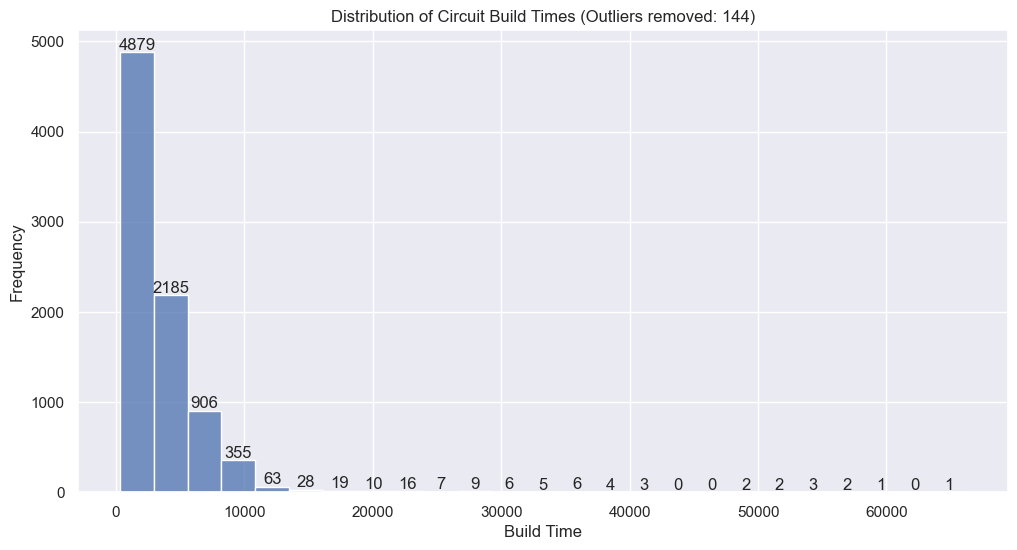

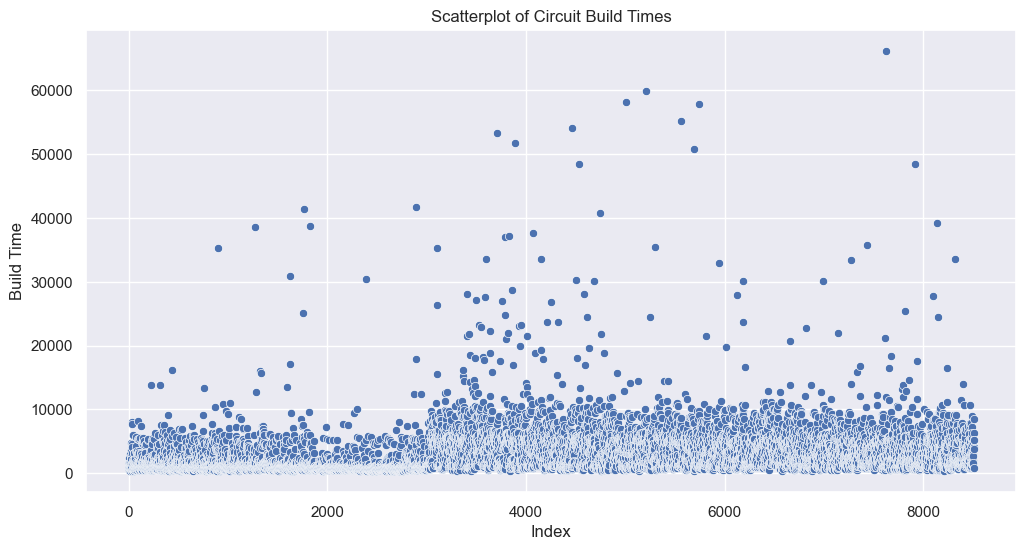

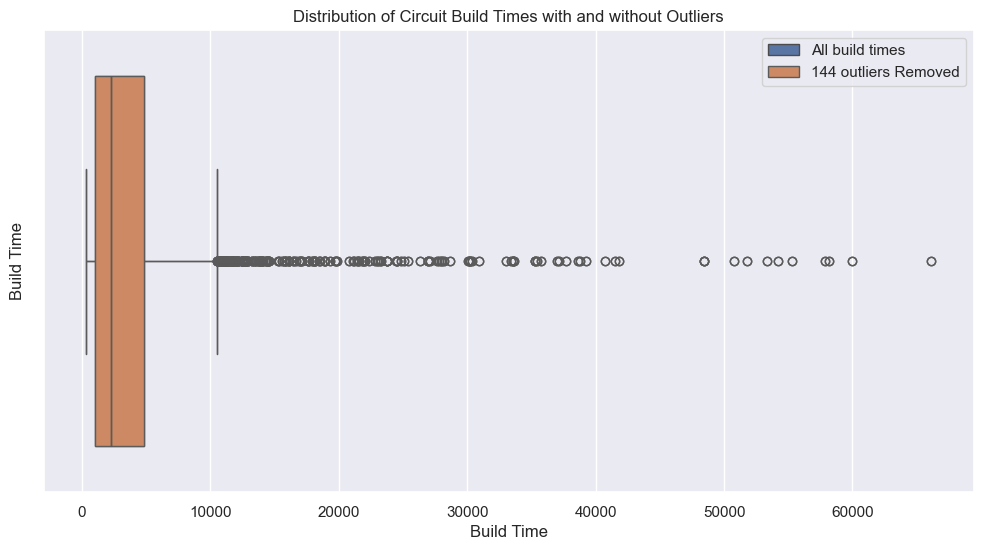

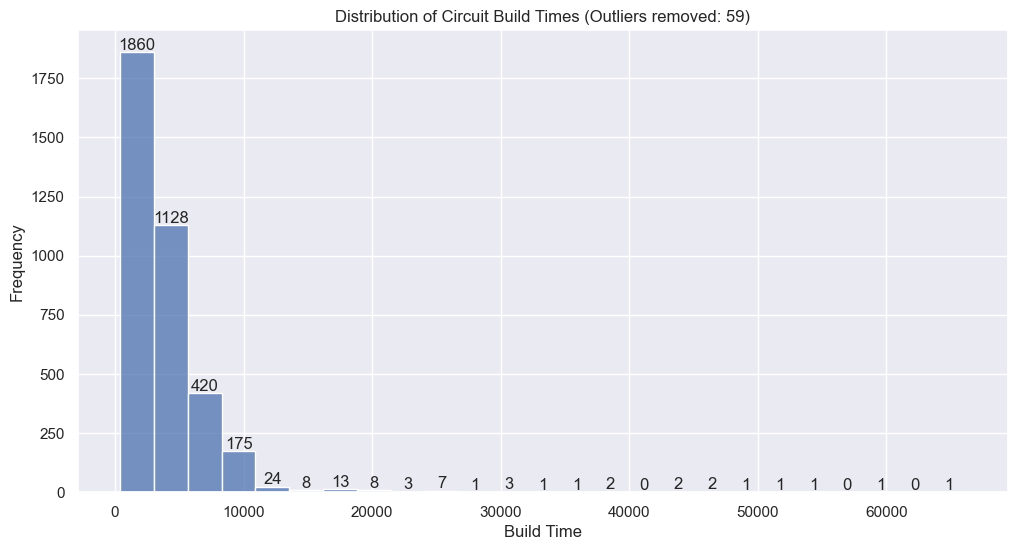

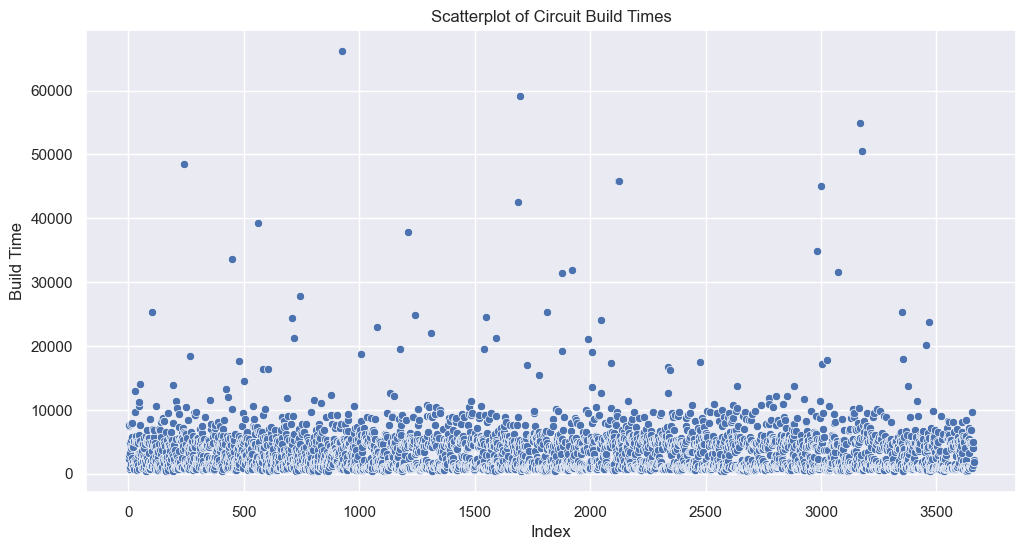

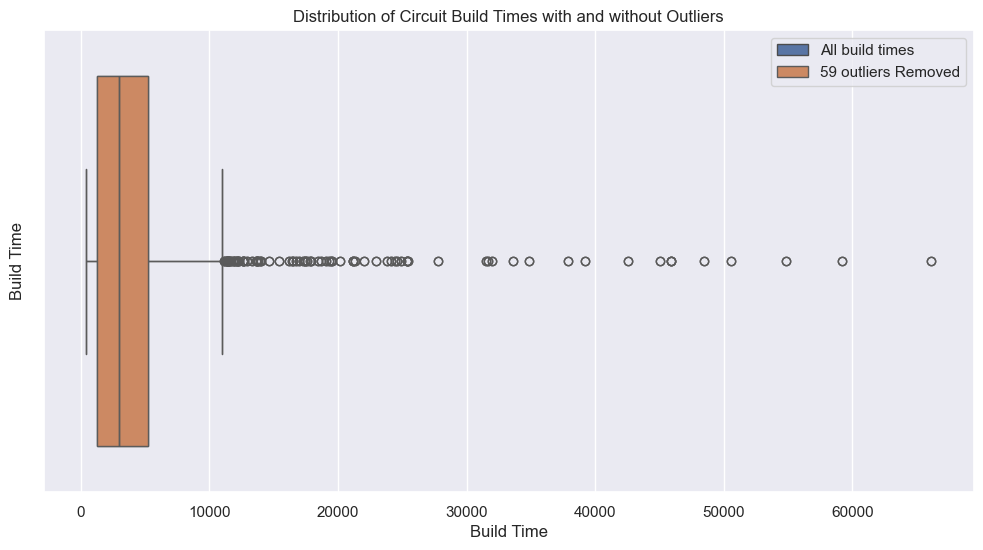

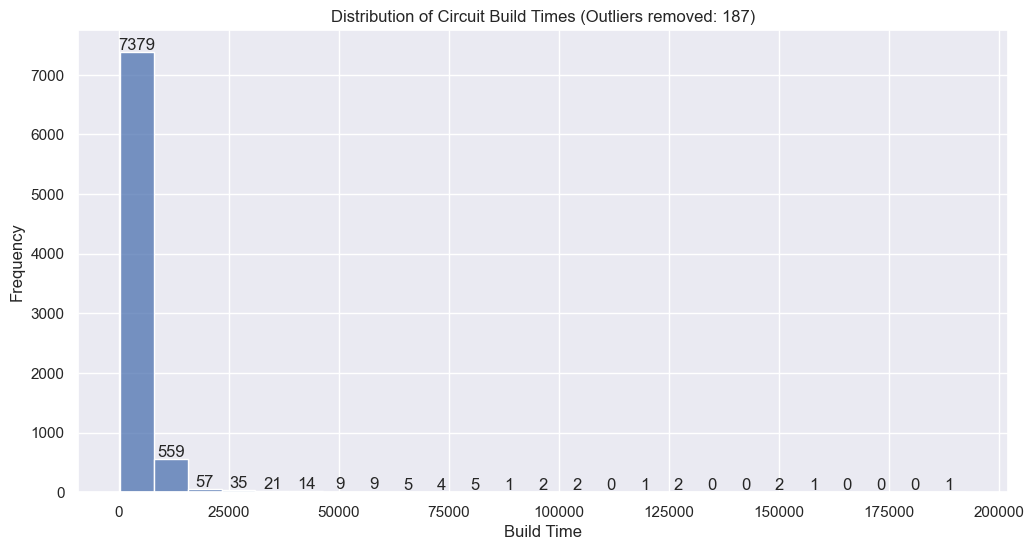

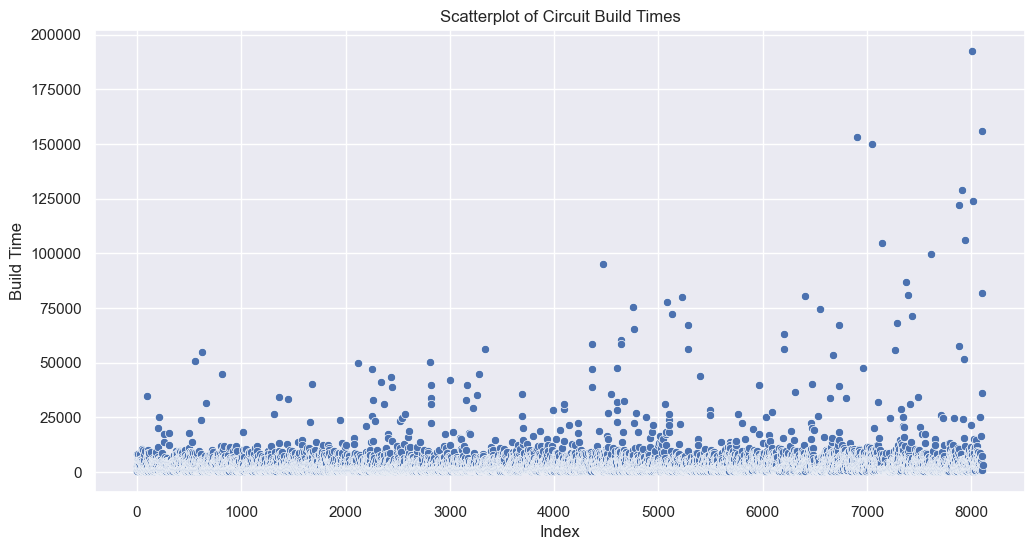

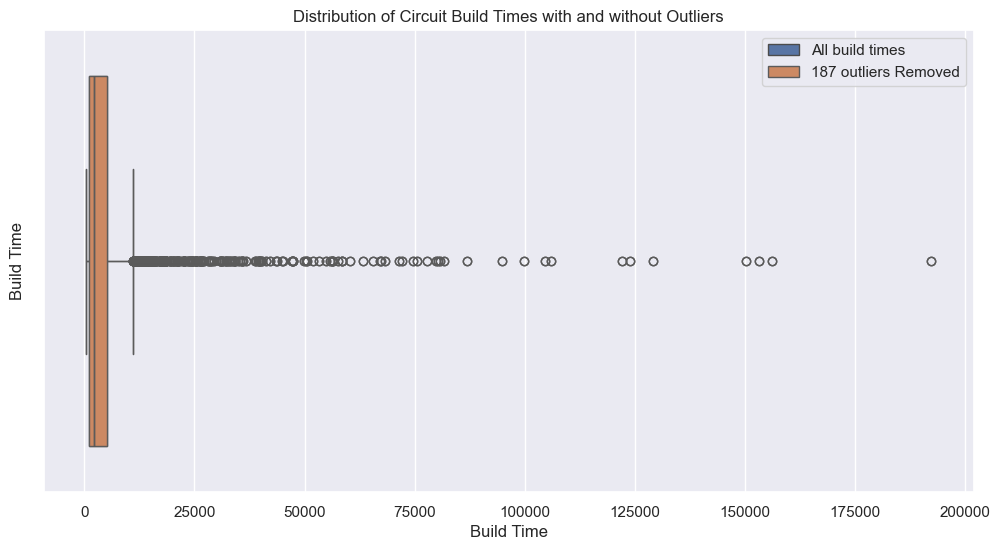

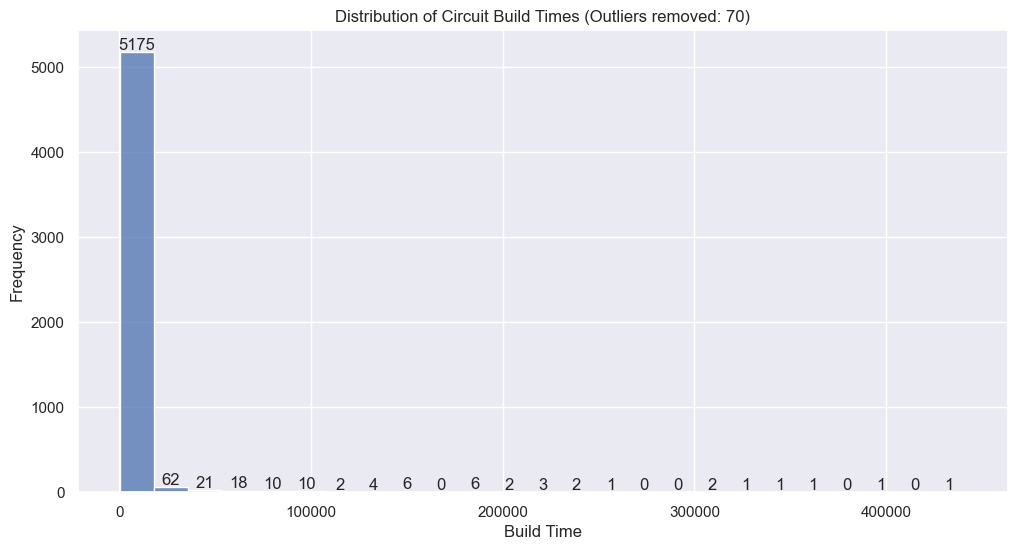

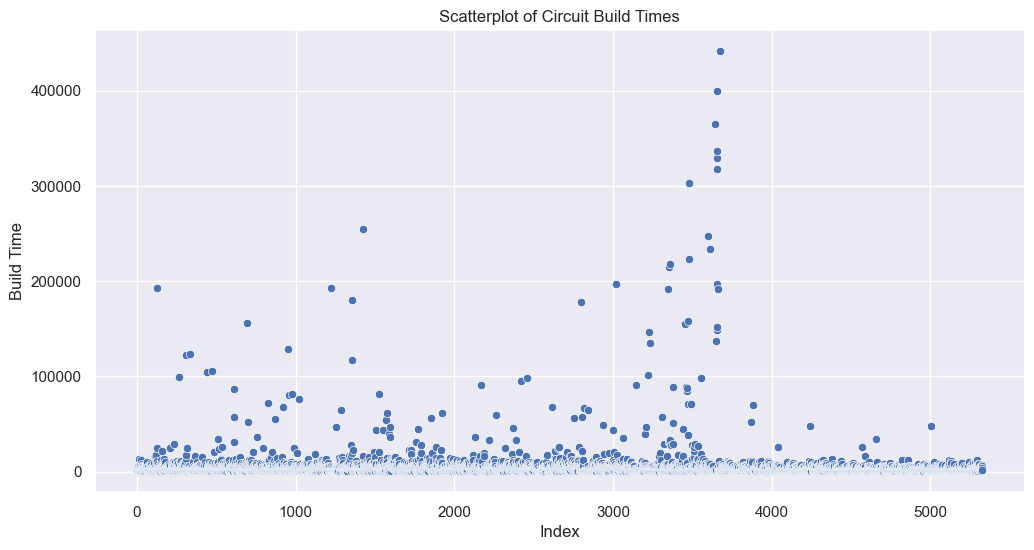

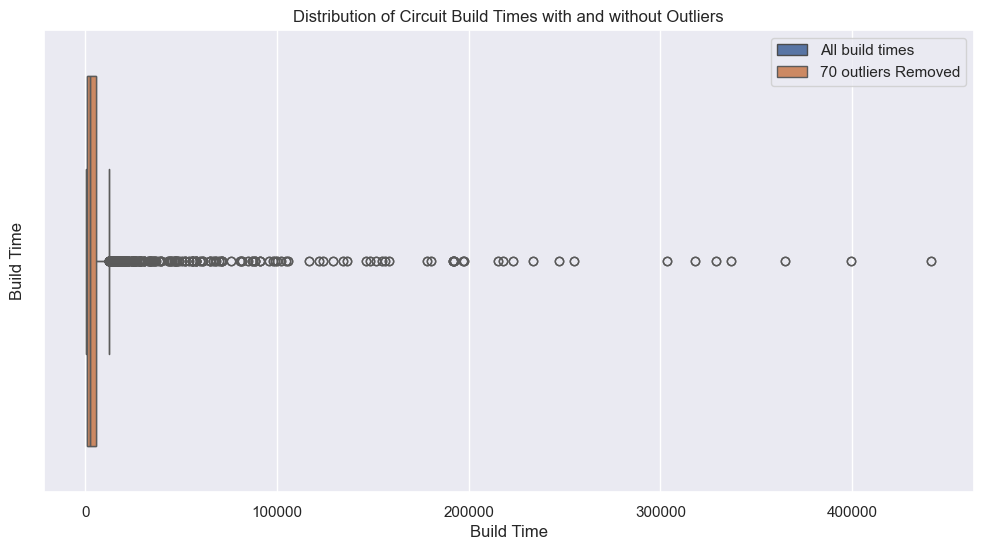

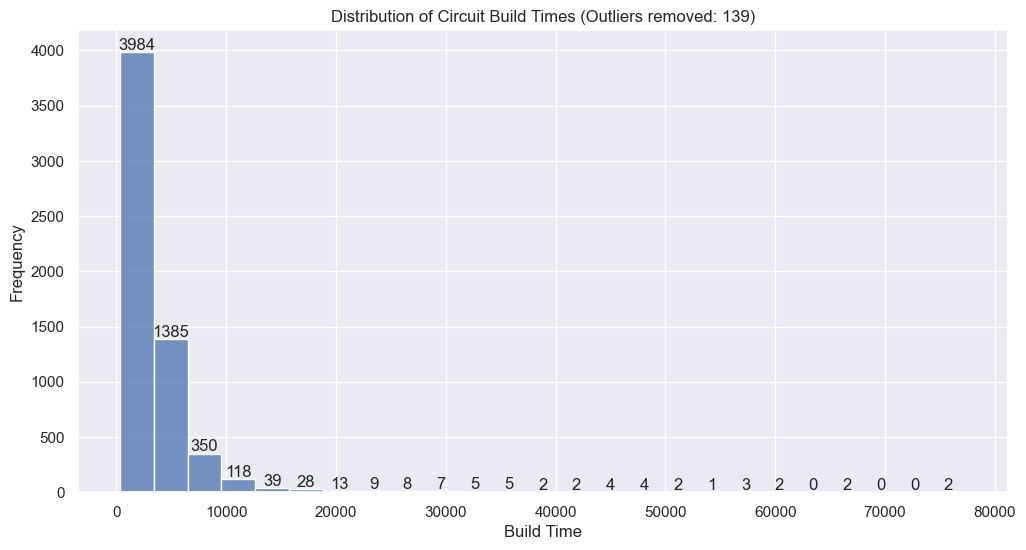

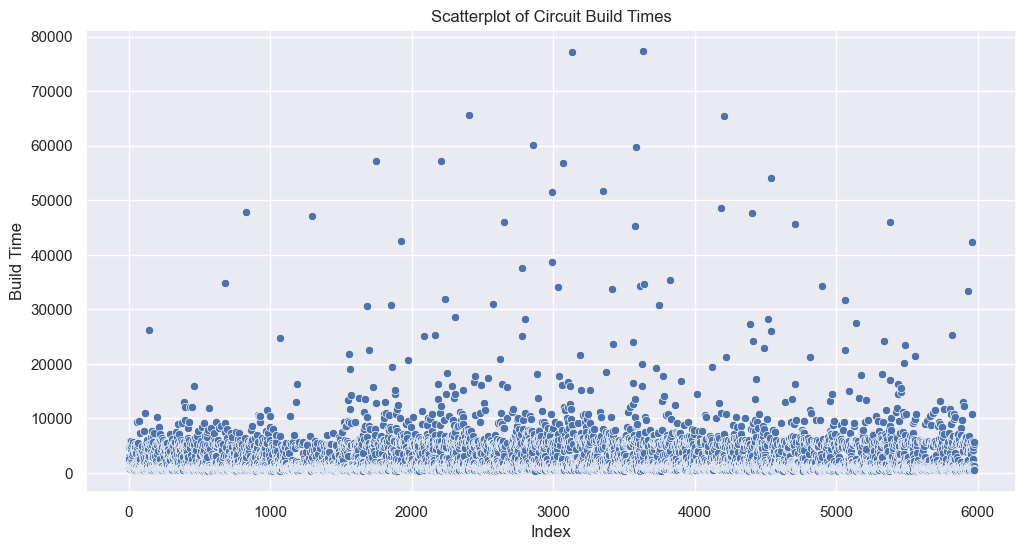

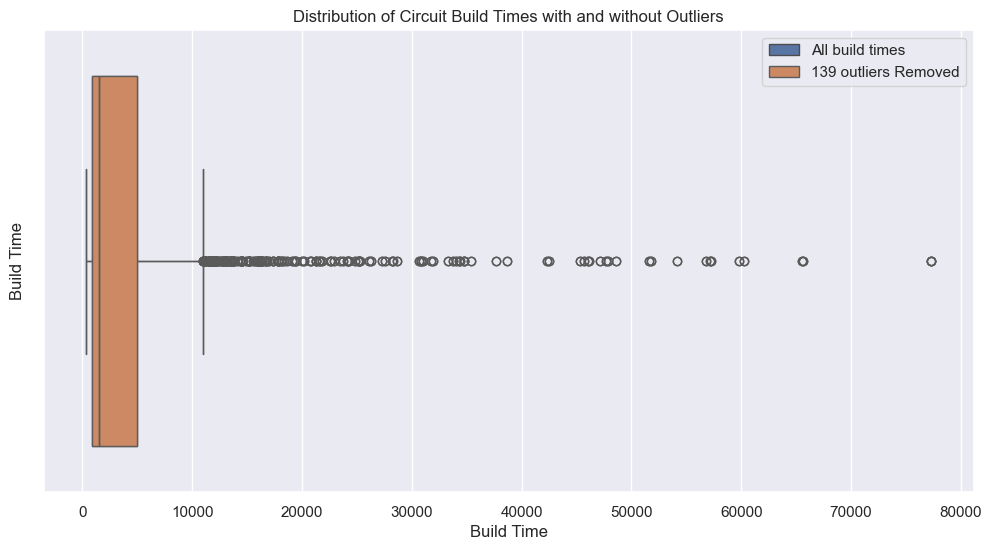

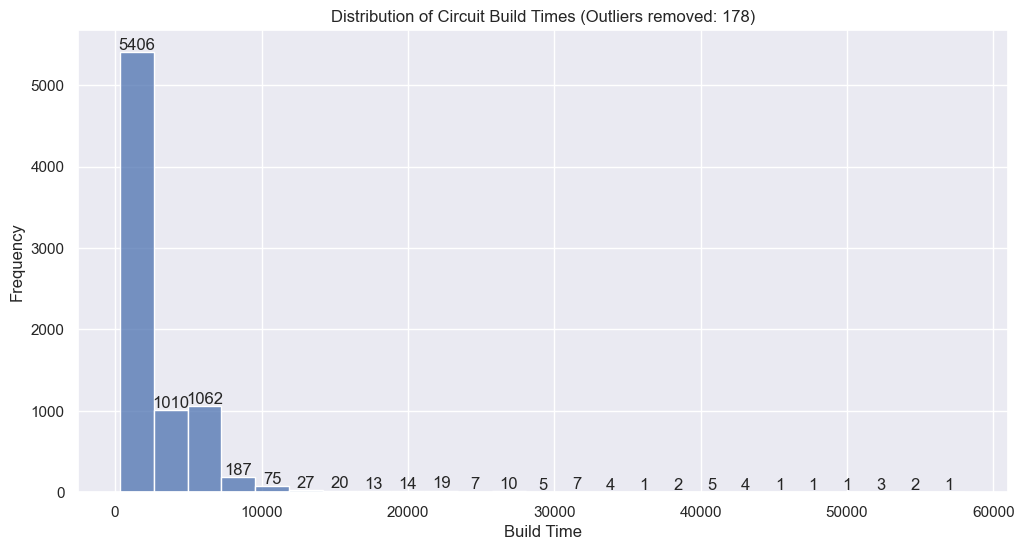

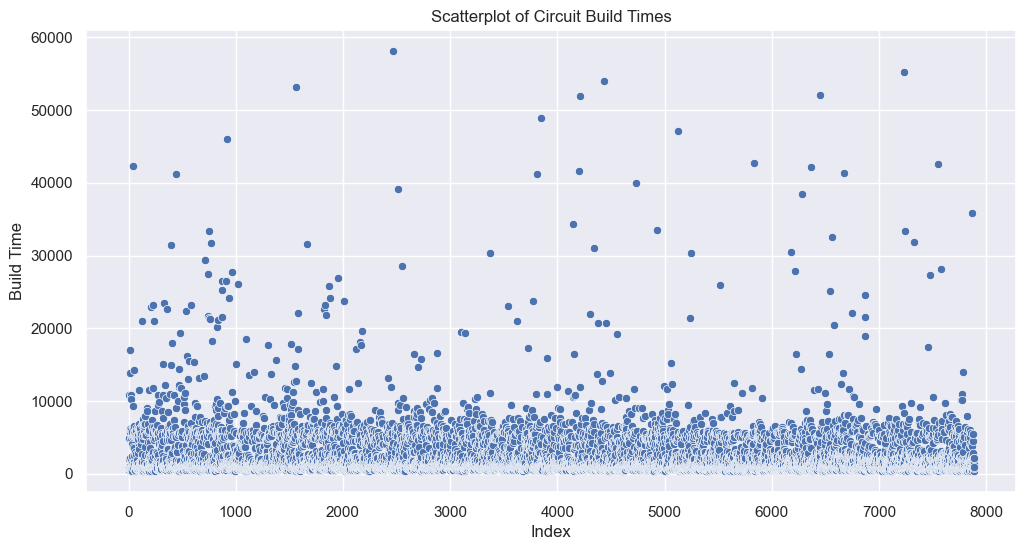

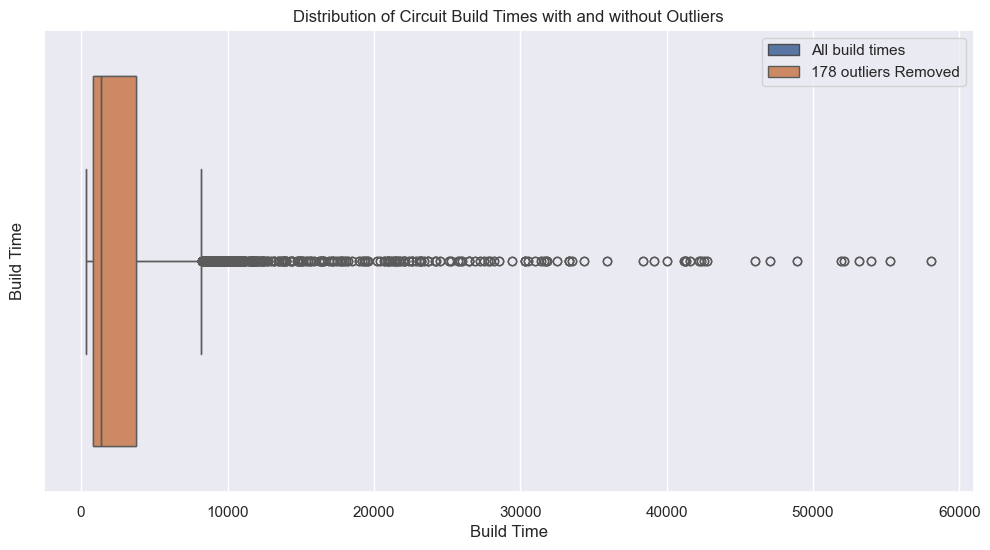

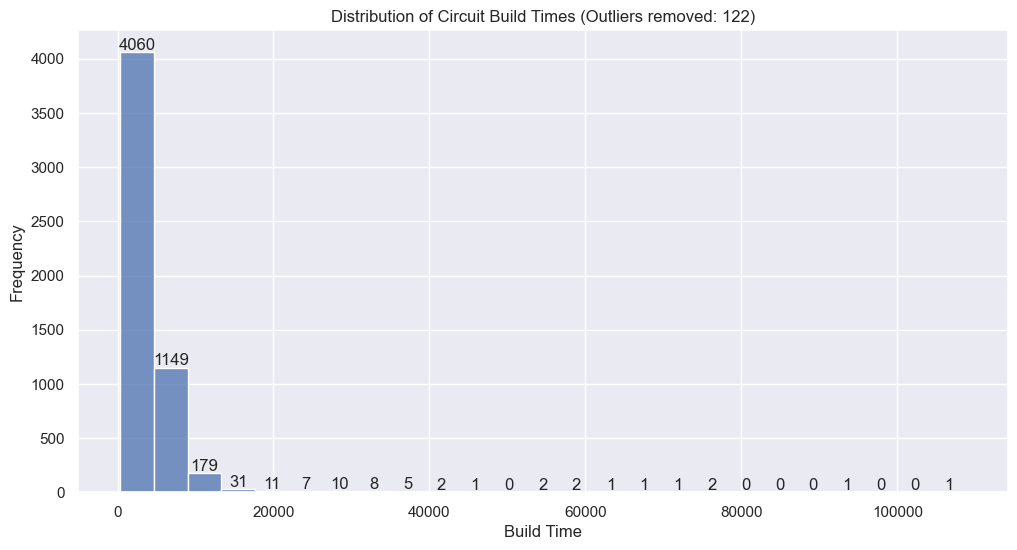

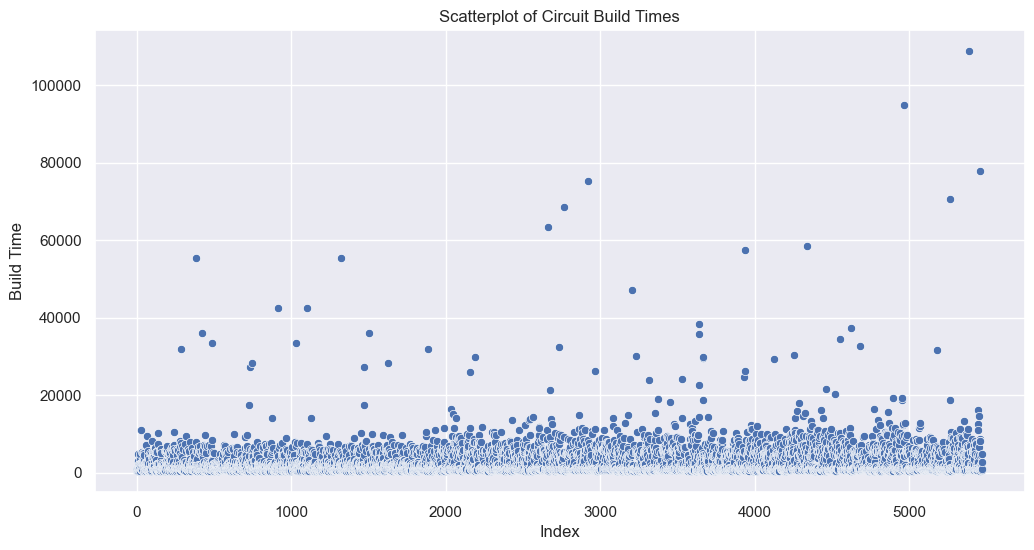

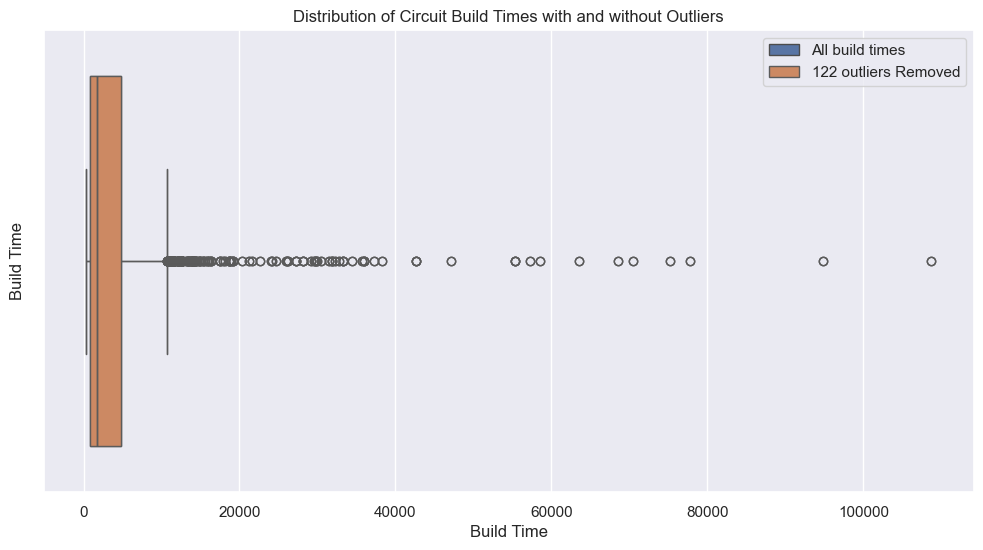

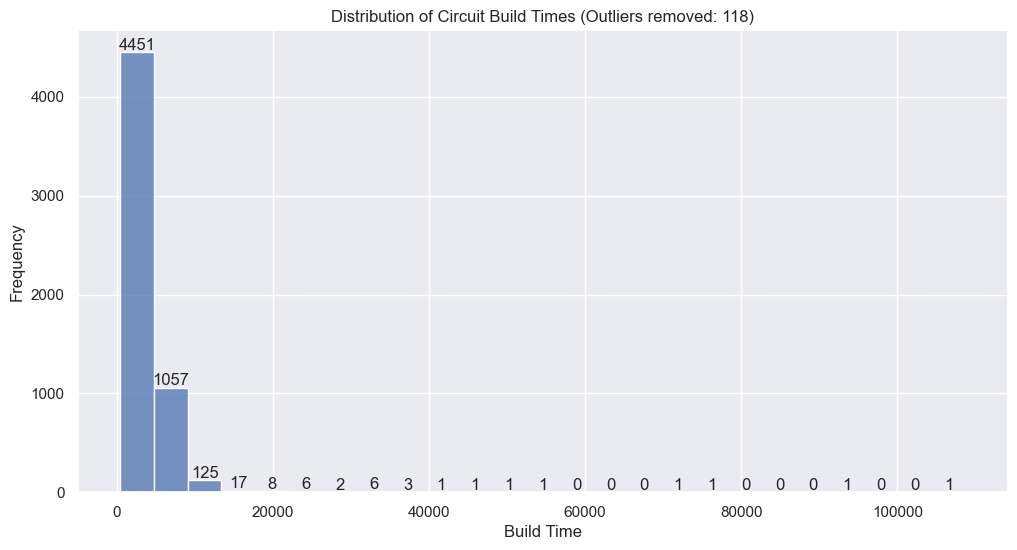

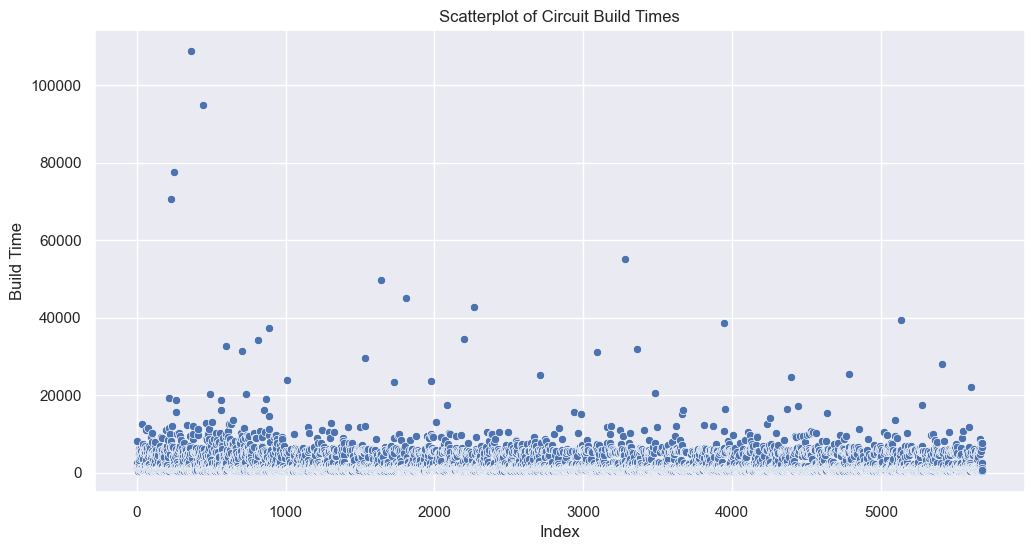

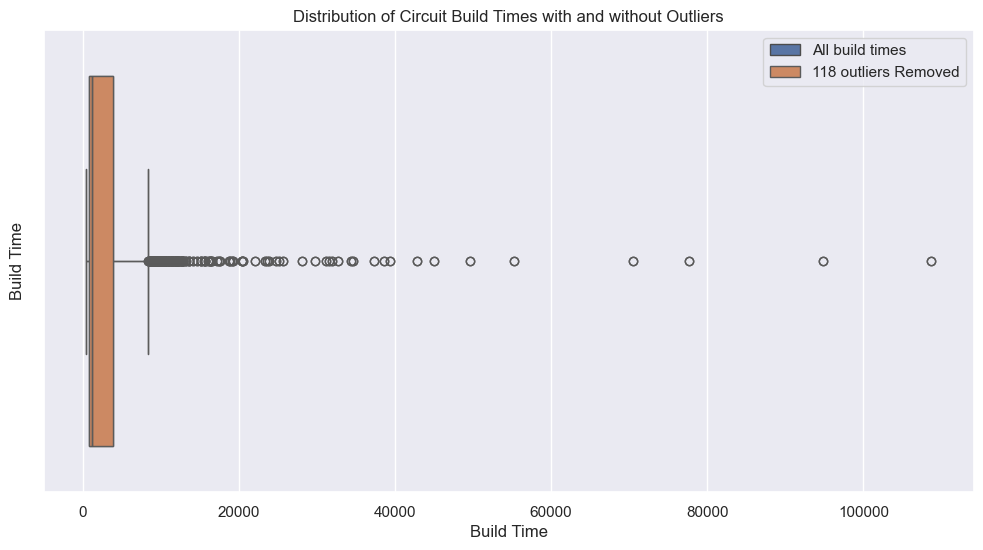

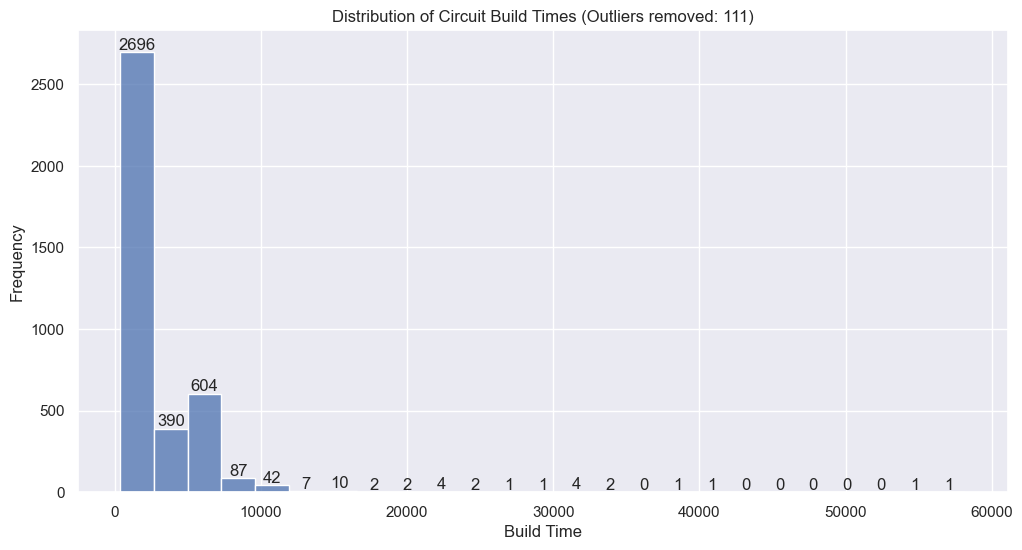

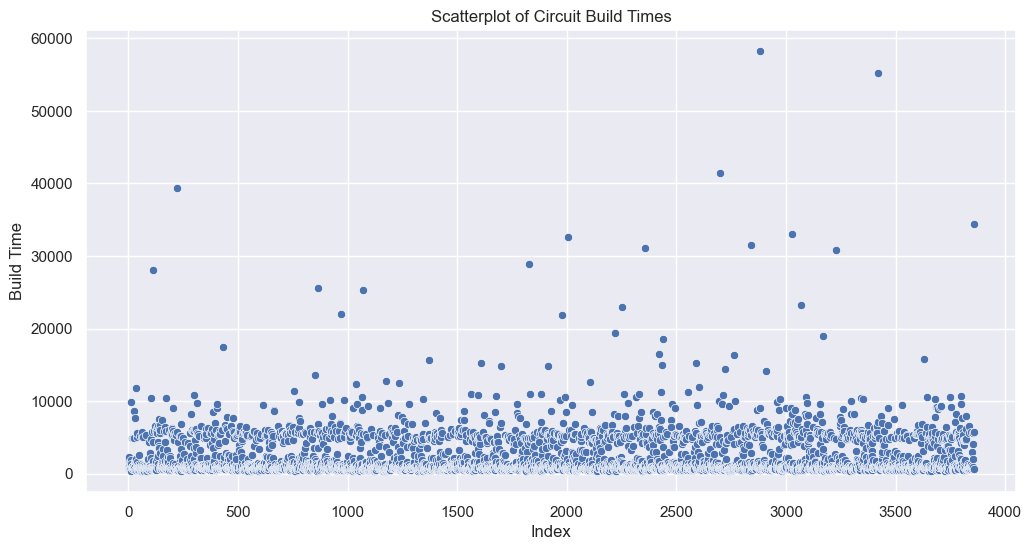

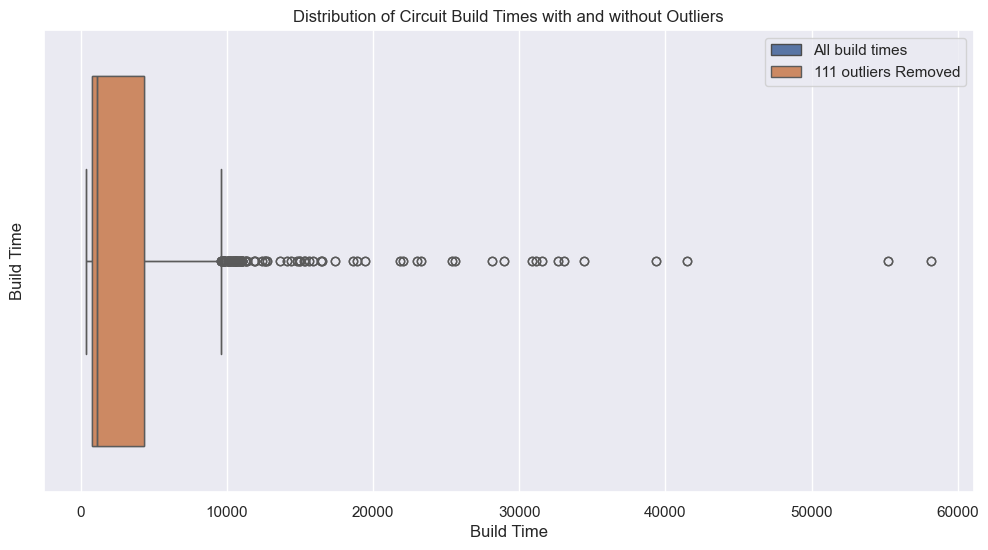

In [28]:
# build_times_filename = input("Enter filename of the build times file to use: ")
for i in range(1, 10):
    build_times_filename = f'5000_run_with_ublock_{i}.log_circuit_build_times_add_time.txt'
    build_times_file = f'../log_analysis/{build_times_filename}'
    build_times_stats_file = f'../log_analysis/{build_times_filename}_stats.txt'
    searchterm = r"circuit_build_times_add_time\(\): Adding circuit build time (\d+\.?\d*)"
    build_times, outlier_count = extract_build_times_all(build_times_file, build_times_filename, searchterm)
    circuit_build_times_histogram(build_times, outlier_count, build_times_filename)
    build_time_stats(build_times, build_times_stats_file)
    circuit_build_times_scatterplot(build_times, build_times_filename)
    circuit_build_times_boxplot(build_times, outlier_count, build_times_filename)
    

Number of outliers: 1128


/tmp/ipykernel_211060/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Minimum build time: 320.0
Maximum build time: 441367.0
Mean build time: 3483.200477151771


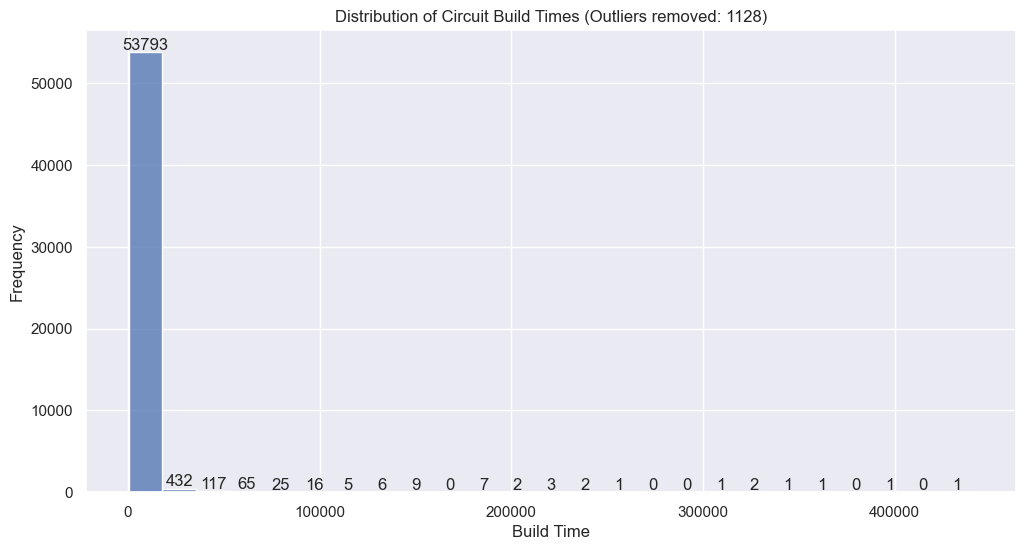

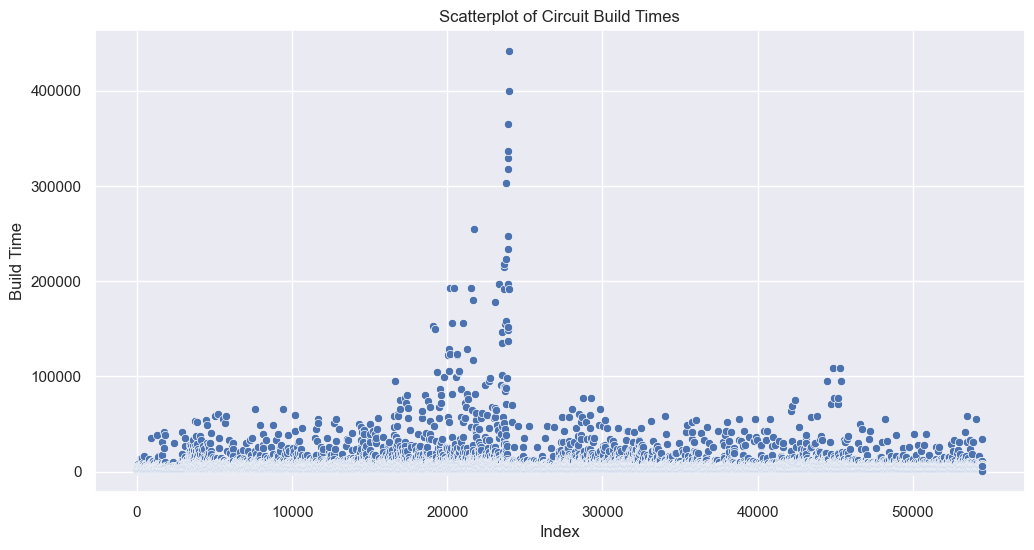

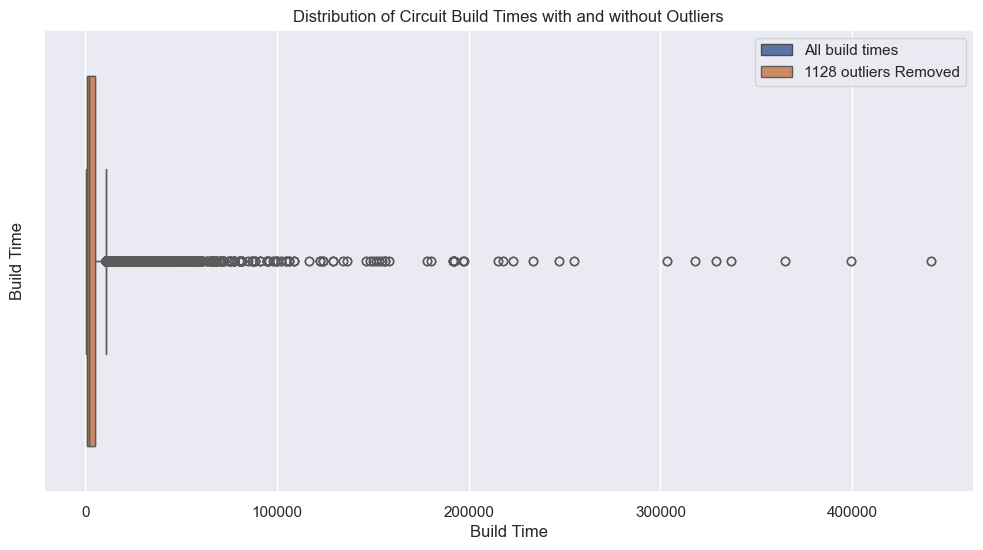

In [34]:
build_times_filename = input("Enter filename of the build times file to use: ")
build_times_file = f'../log_analysis/{build_times_filename}'
build_times_stats_file = f'../log_analysis/{build_times_filename}_stats.txt'
searchterm = r"circuit_build_times_add_time\(\): Adding circuit build time (\d+\.?\d*)"
build_times, outlier_count = extract_build_times_all(build_times_file, build_times_filename, searchterm)
circuit_build_times_histogram(build_times, outlier_count, build_times_filename)
build_time_stats(build_times, build_times_stats_file)
circuit_build_times_scatterplot(build_times, build_times_filename)
circuit_build_times_boxplot(build_times, outlier_count, build_times_filename)


Number of outliers: 0
Minimum build time: 1499.799501
Maximum build time: 7752.300995
Mean build time: 5951.0727236791045


/tmp/ipykernel_261719/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 0
Minimum build time: 5248.698522
Maximum build time: 5513.294514
Mean build time: 5476.764463


/tmp/ipykernel_261719/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 0
Minimum build time: 3411.269592
Maximum build time: 6831.815268
Mean build time: 4767.965525035714


/tmp/ipykernel_261719/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 0
Minimum build time: 3473.836993
Maximum build time: 7843.874812
Mean build time: 6559.5151018999995


/tmp/ipykernel_261719/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 0
Minimum build time: 2494.824585
Maximum build time: 4546.752746
Mean build time: 3689.481671024391


/tmp/ipykernel_261719/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 0
Minimum build time: 2491.94492
Maximum build time: 3998.274083
Mean build time: 3101.229687704546


/tmp/ipykernel_261719/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 0
Minimum build time: 2971.536676
Maximum build time: 4519.371246
Mean build time: 3606.9773048888887


/tmp/ipykernel_261719/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()
/tmp/ipykernel_261719/3645400767.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12,6))
/tmp/ipykernel_261719/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 0
Minimum build time: 2484.497502
Maximum build time: 3775.792295
Mean build time: 2560.066984971831
Number of outliers: 0
Minimum build time: 2462.483681
Maximum build time: 2509.382679
Mean build time: 2495.580309


/tmp/ipykernel_261719/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 0
Minimum build time: 1220.8301
Maximum build time: 18544.448823
Mean build time: 6601.522821031863


/tmp/ipykernel_261719/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 0
Minimum build time: 1429.522795
Maximum build time: 2604.829108
Mean build time: 2284.578837949275


/tmp/ipykernel_261719/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 0
Minimum build time: 1125.339833
Maximum build time: 6725.727569
Mean build time: 5849.6309451612915


/tmp/ipykernel_261719/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


Number of outliers: 0
Minimum build time: 2486.141997
Maximum build time: 5540.191391
Mean build time: 2669.815715769231


/tmp/ipykernel_261719/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


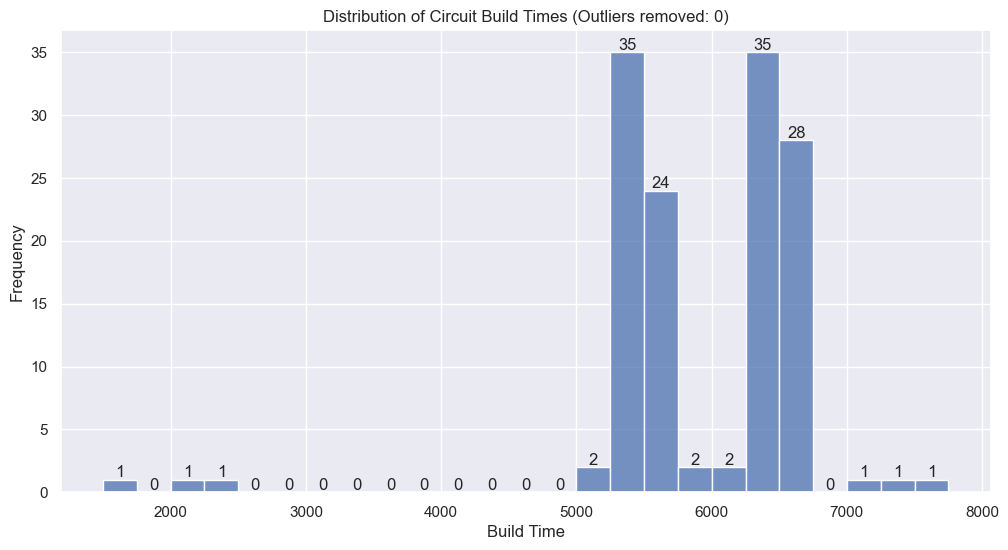

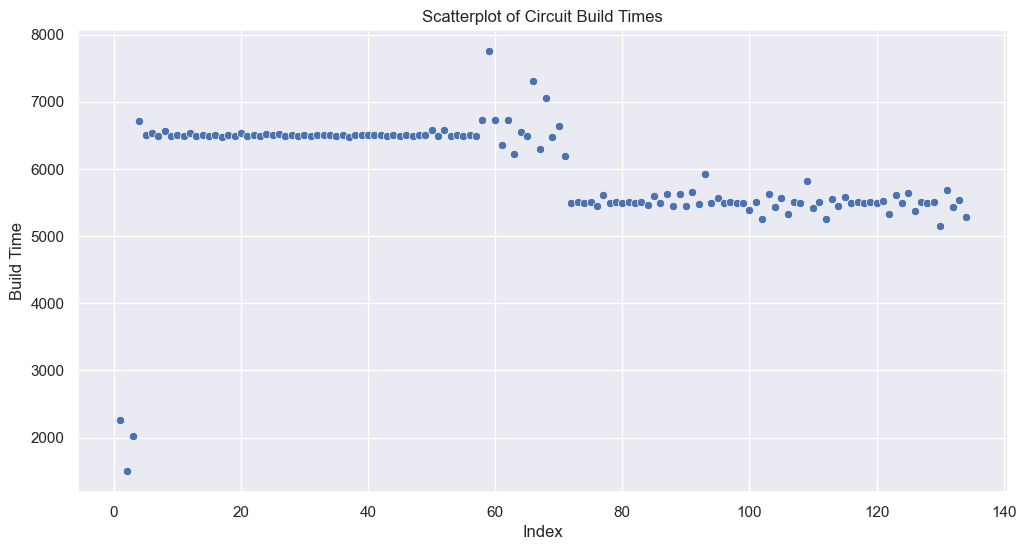

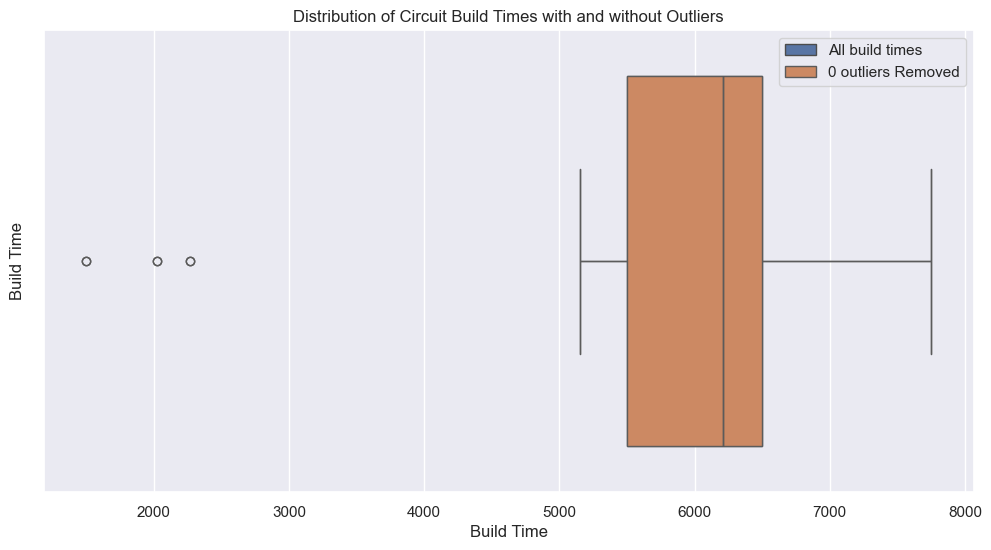

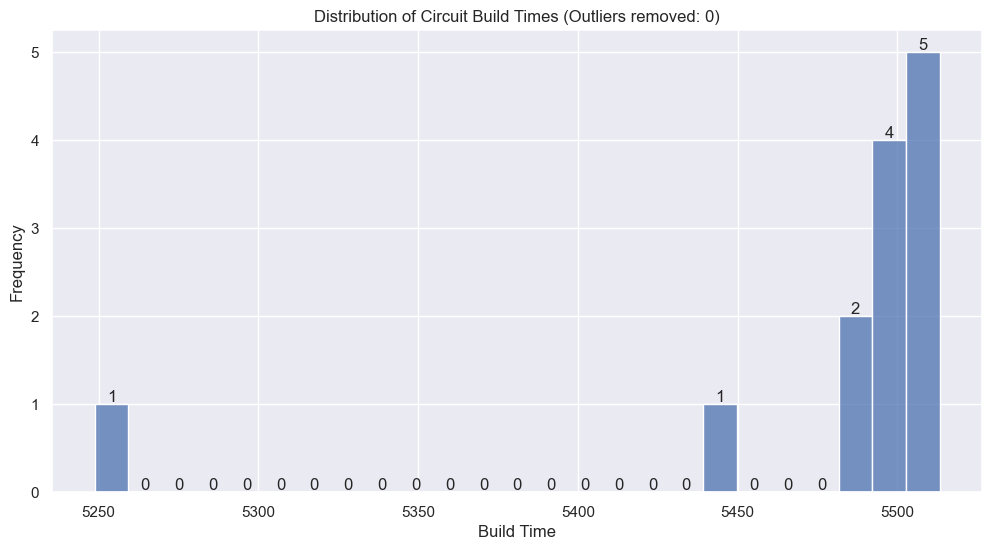

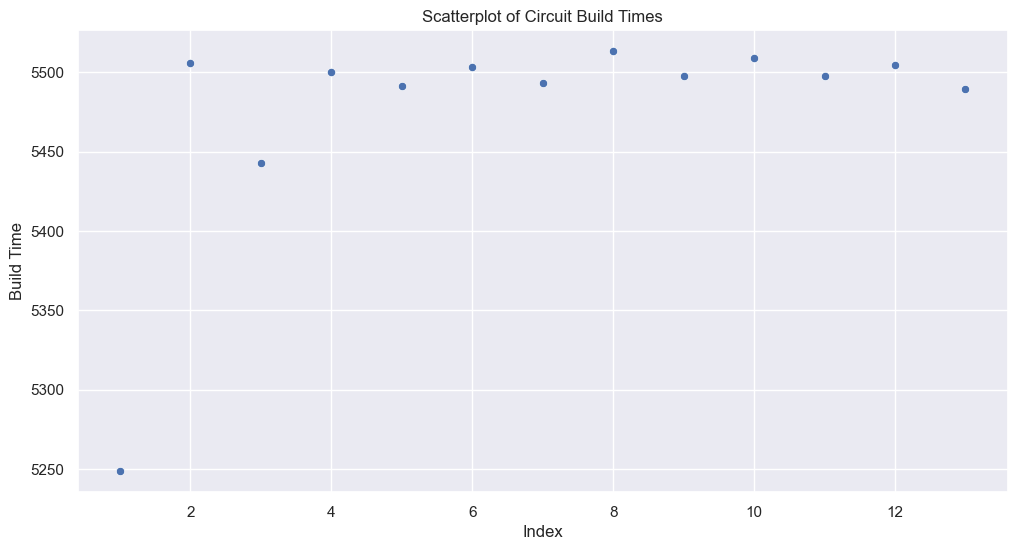

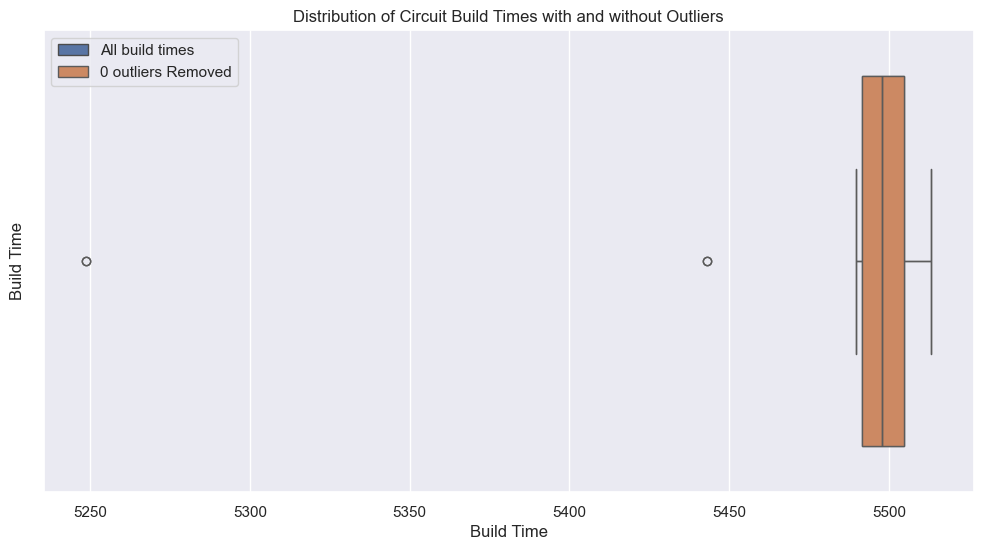

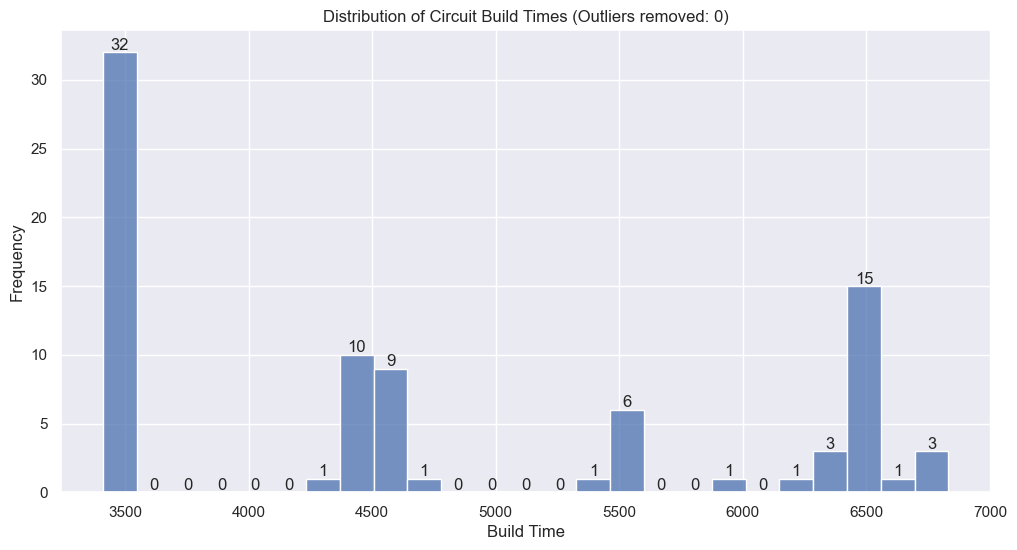

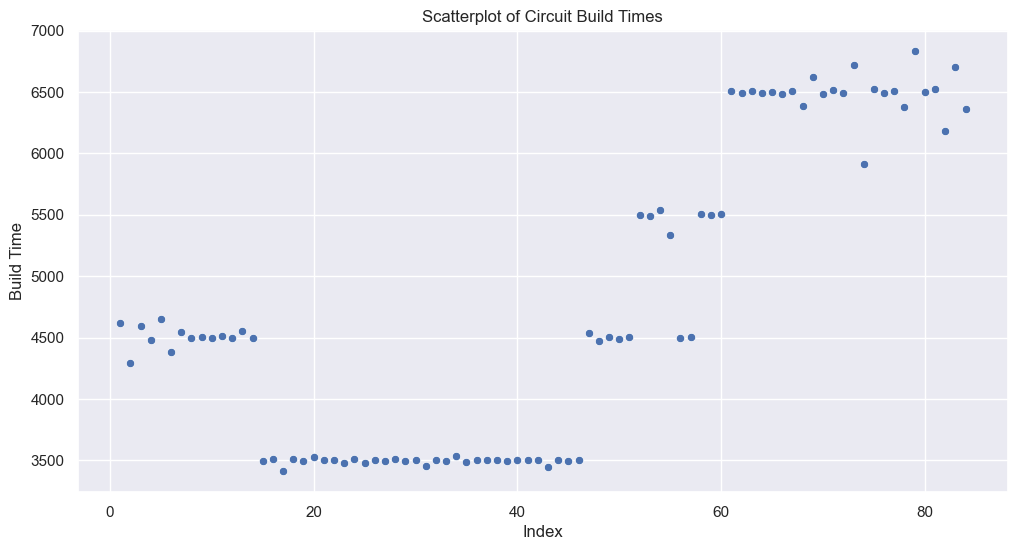

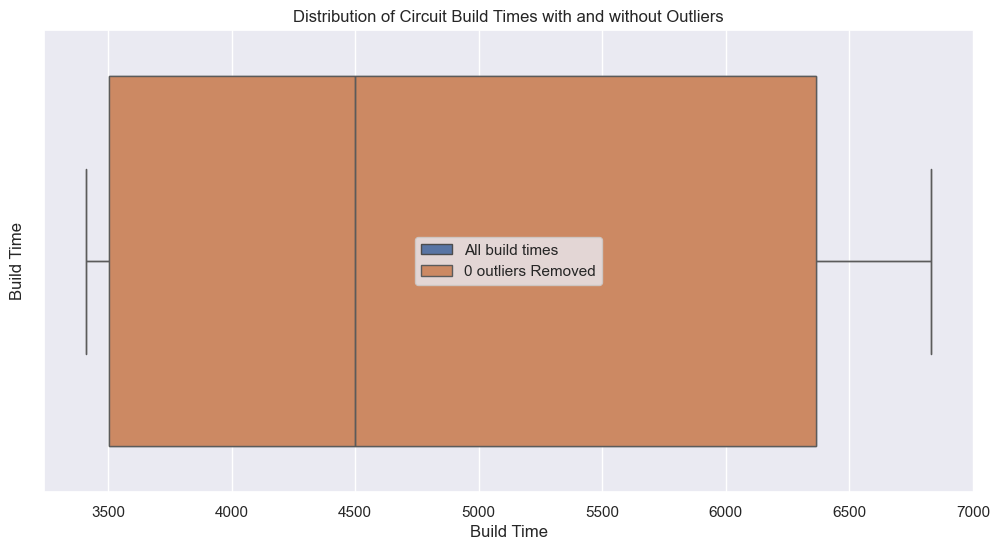

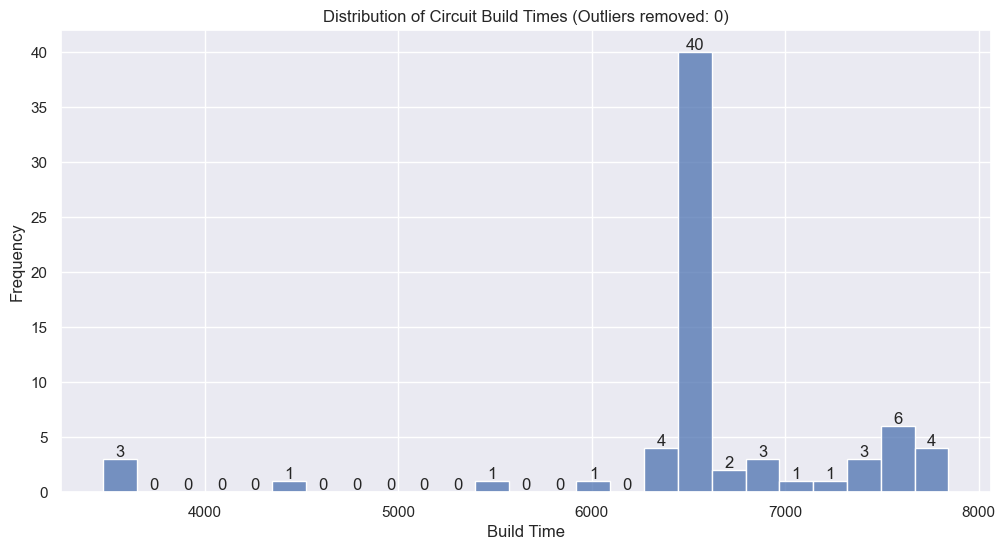

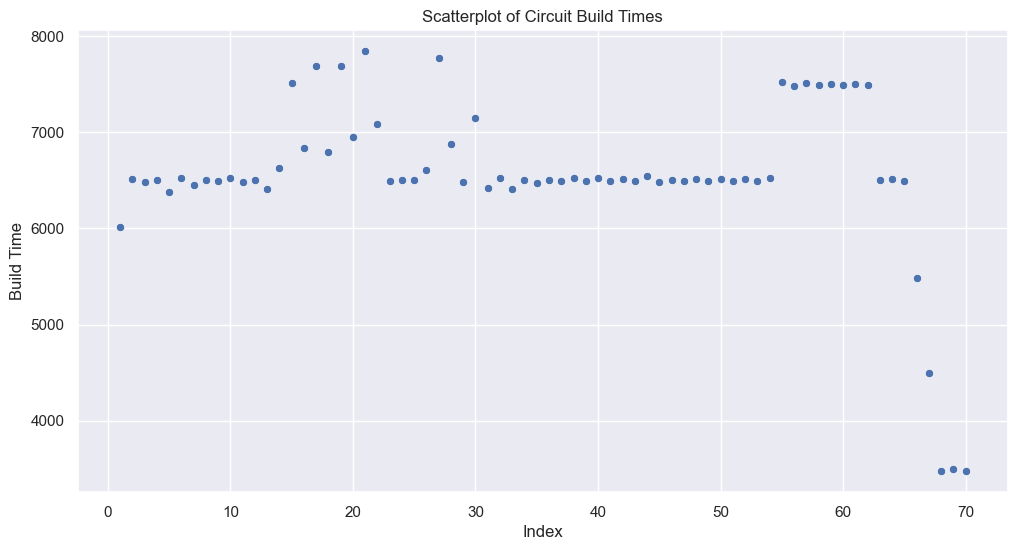

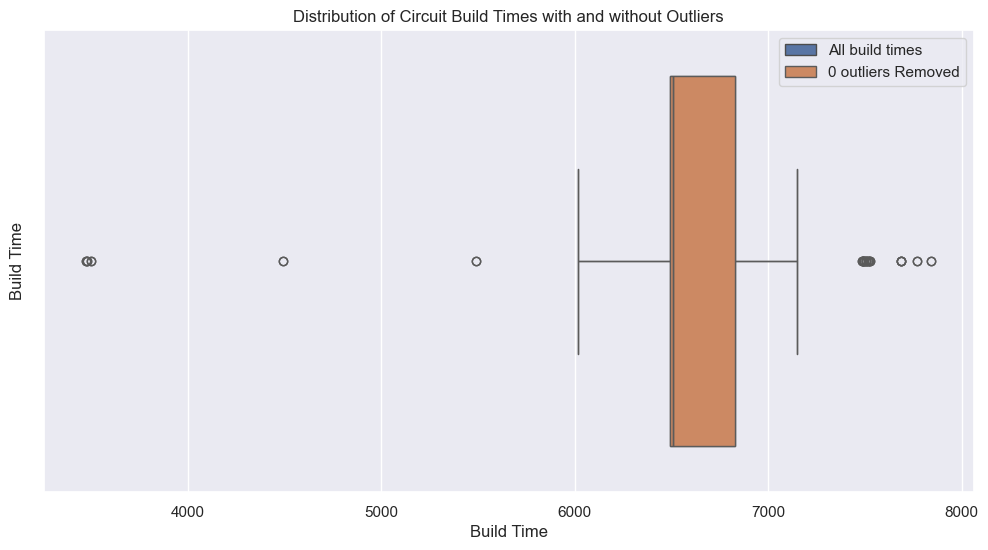

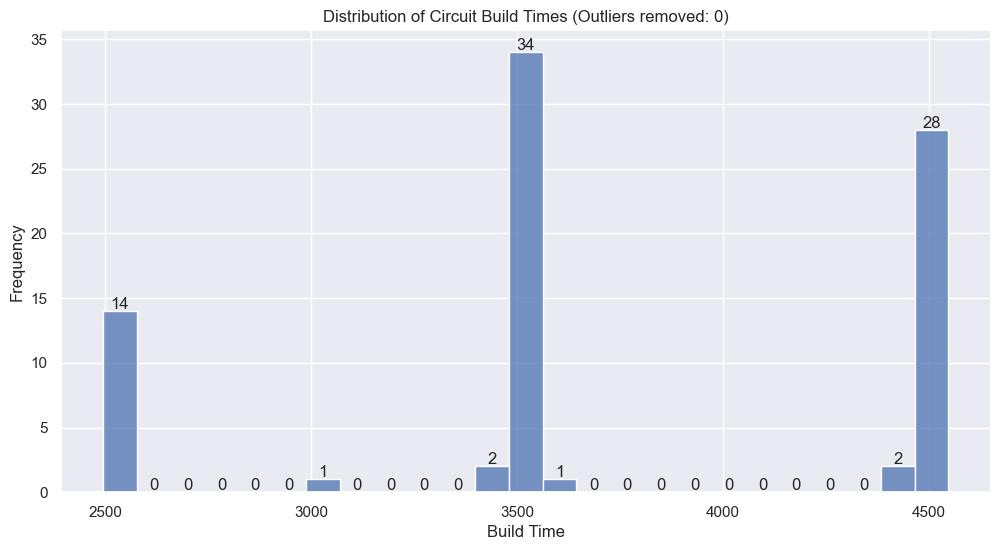

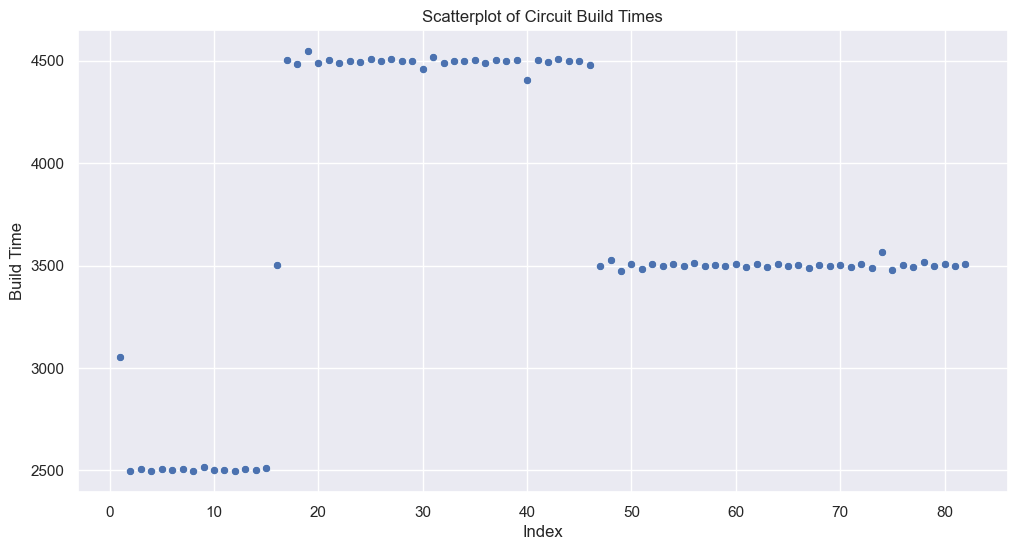

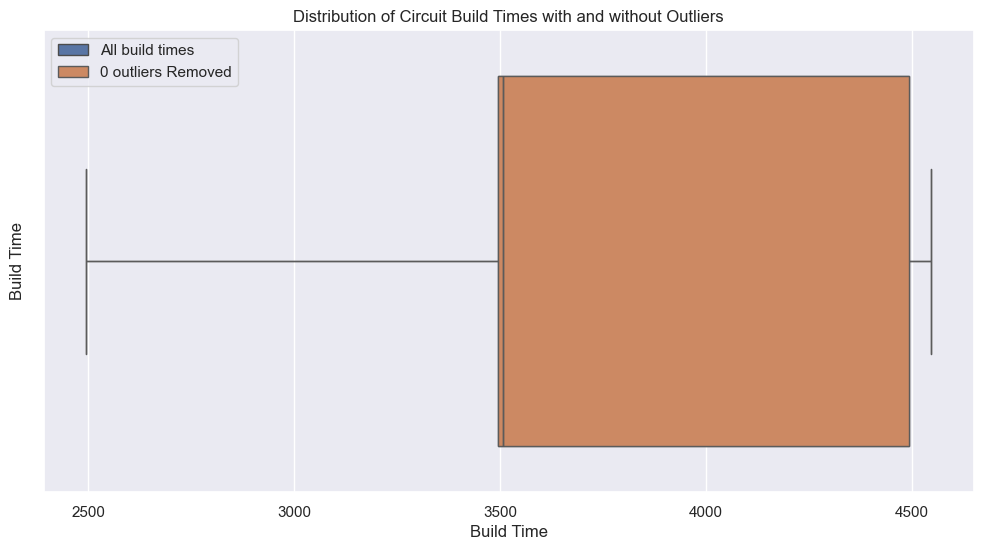

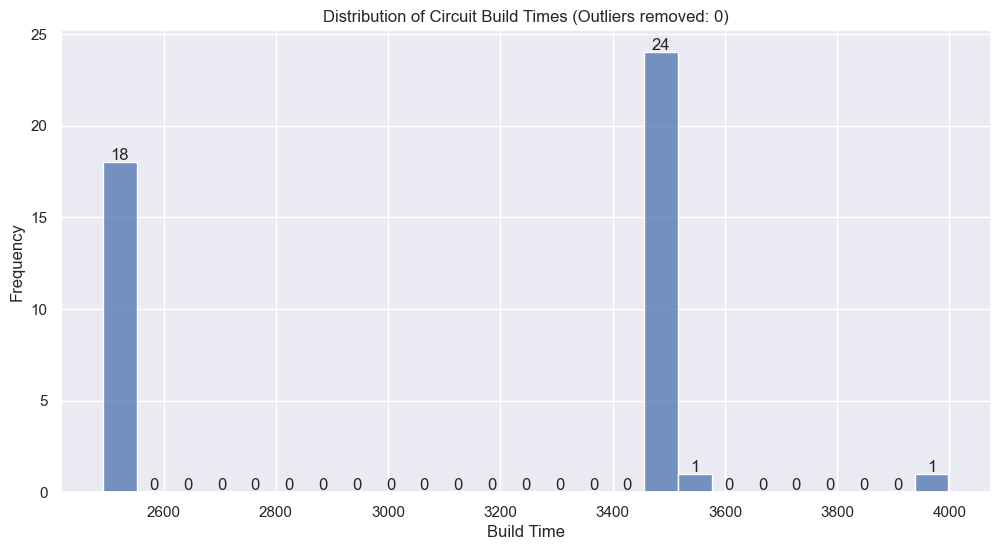

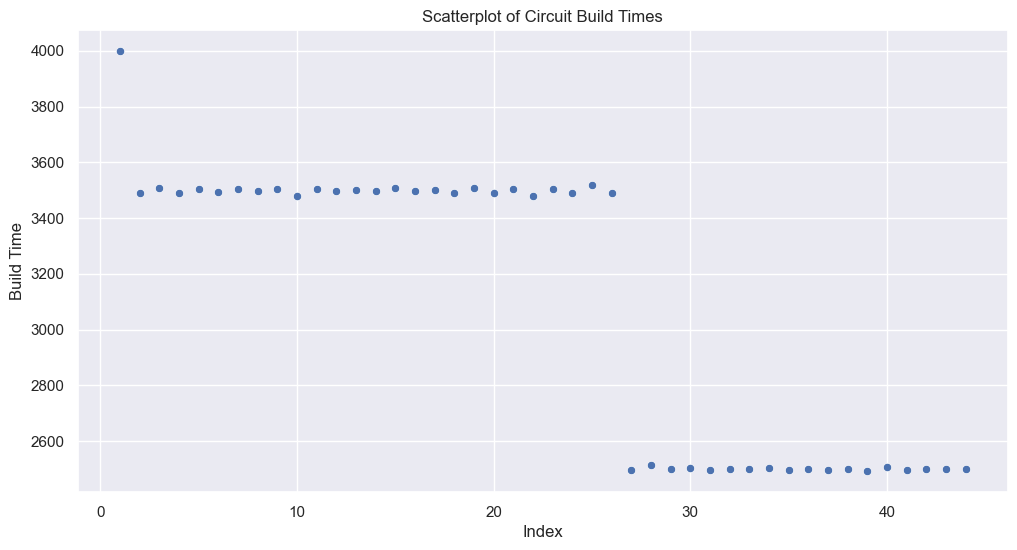

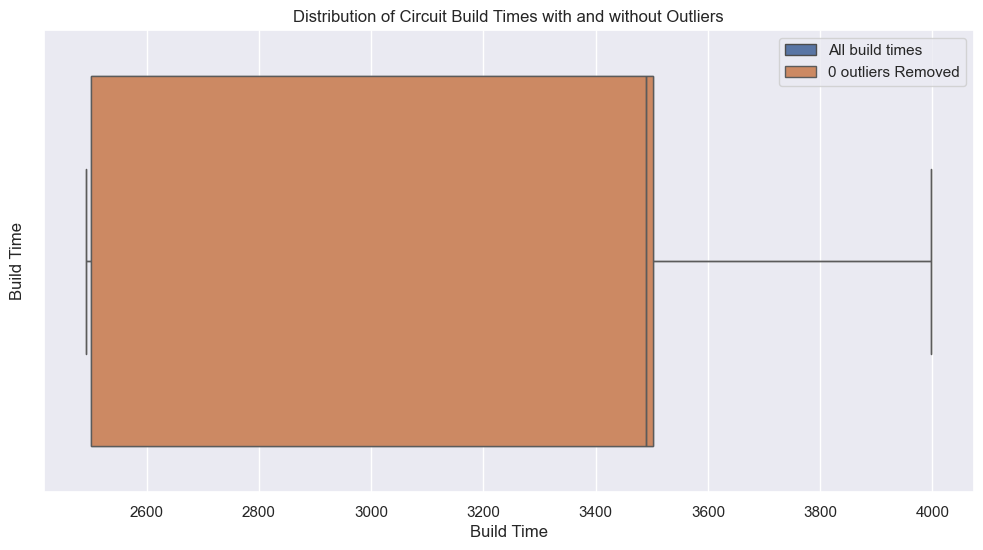

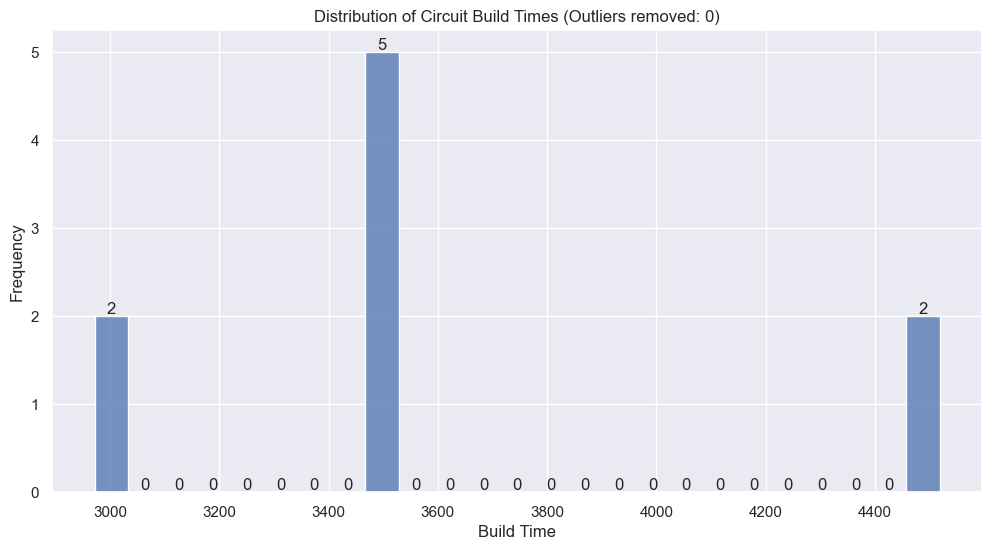

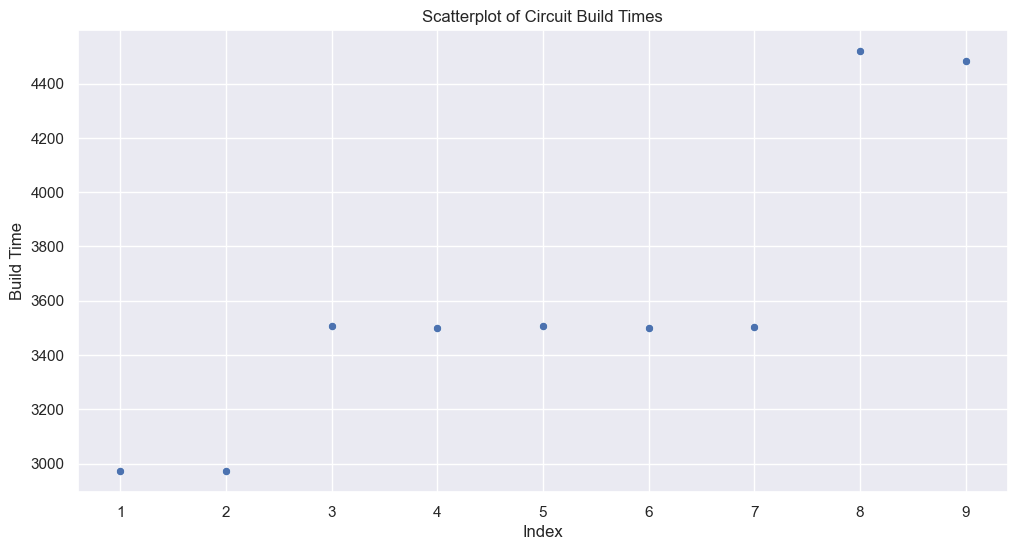

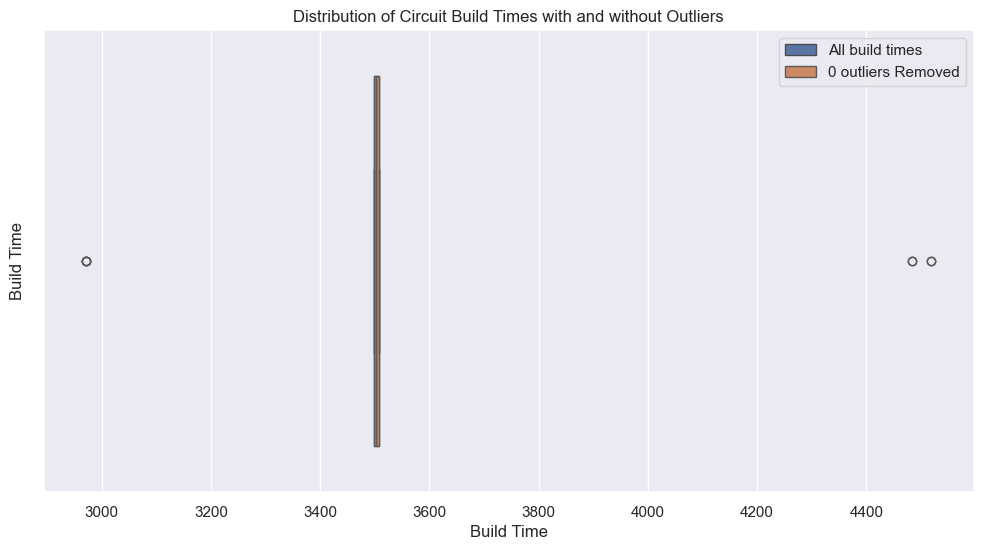

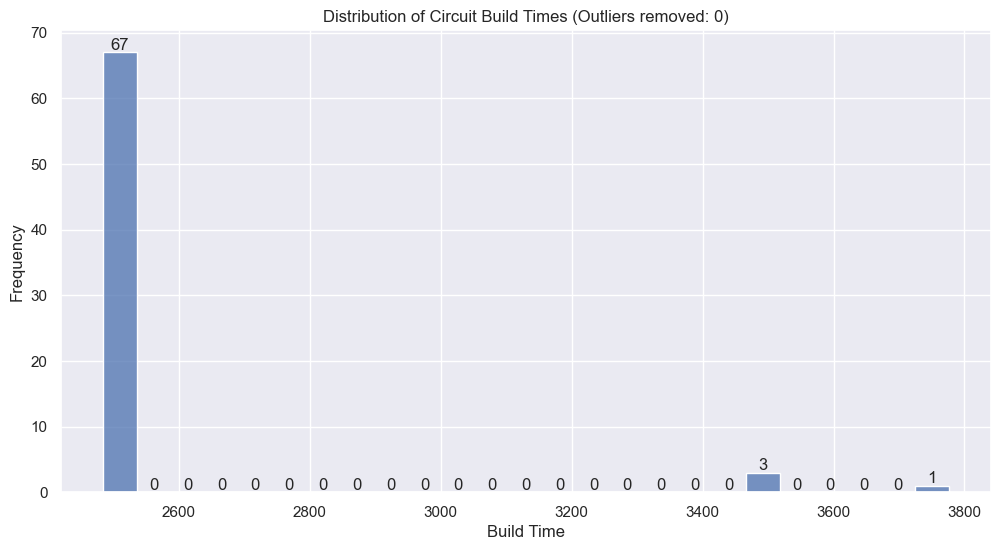

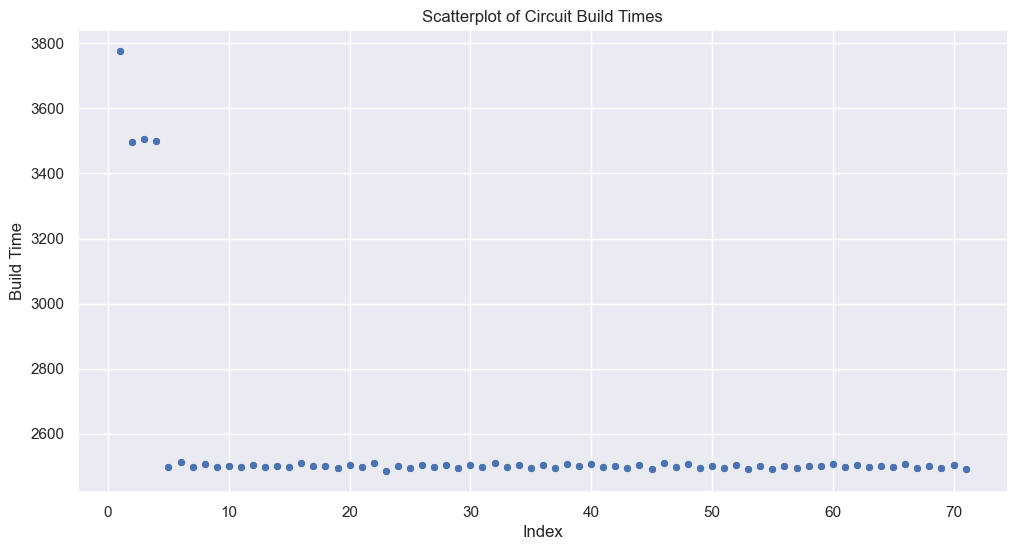

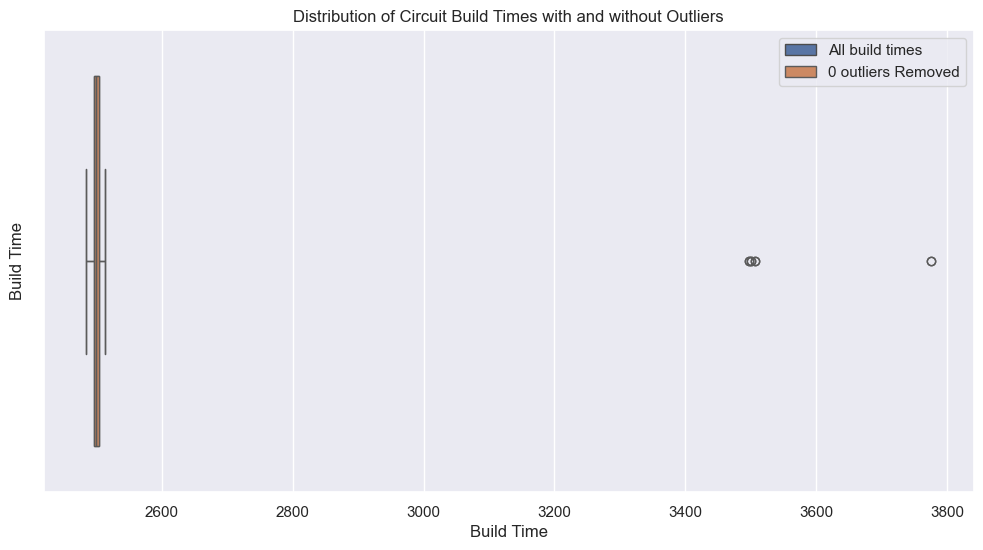

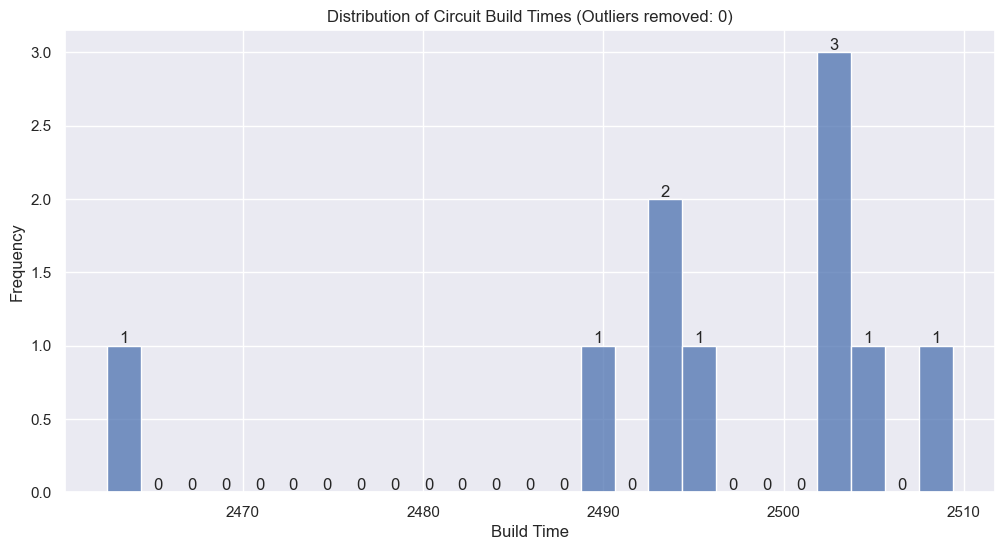

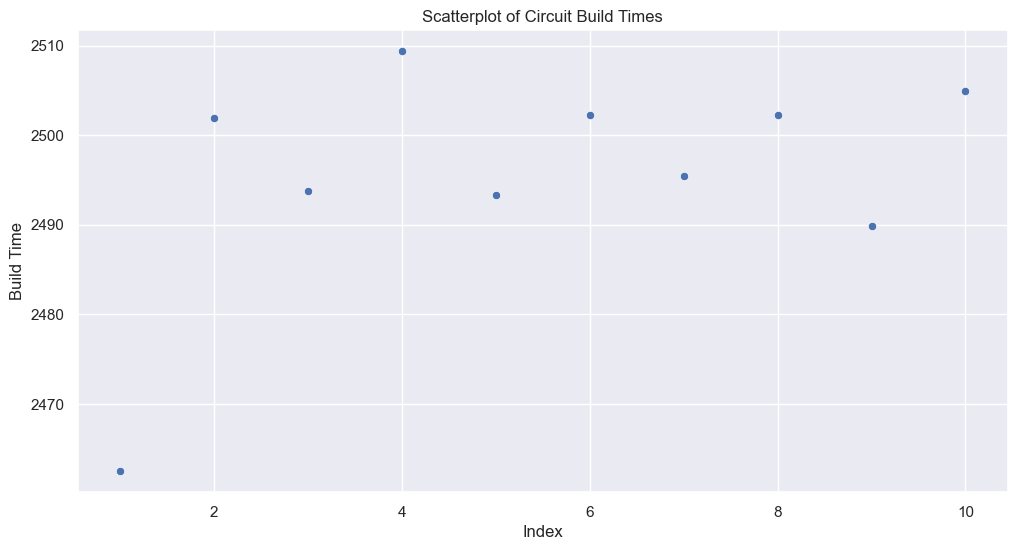

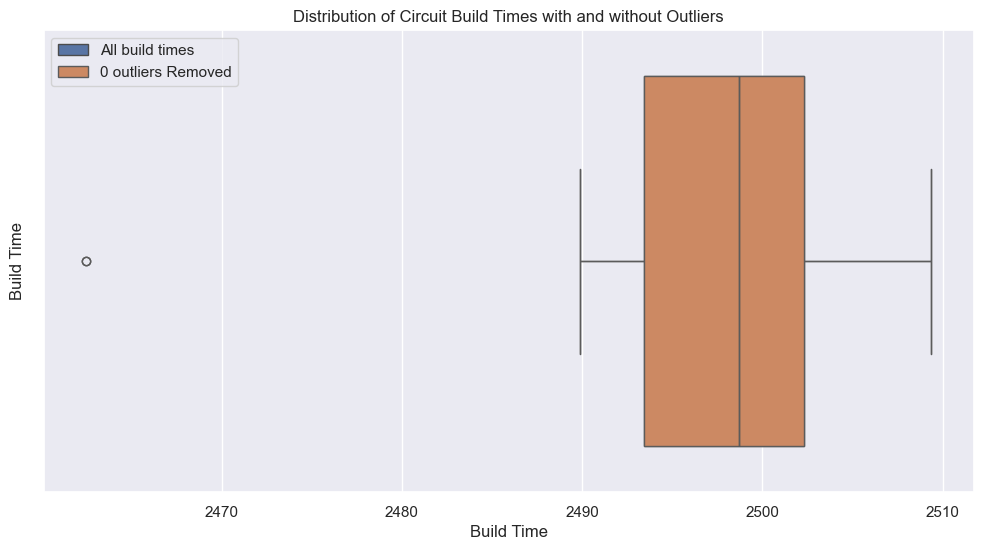

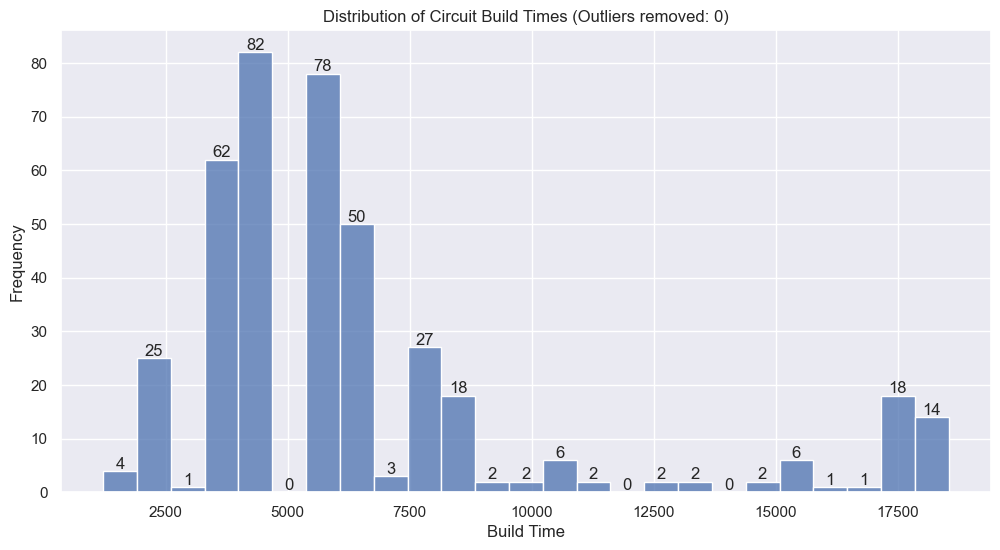

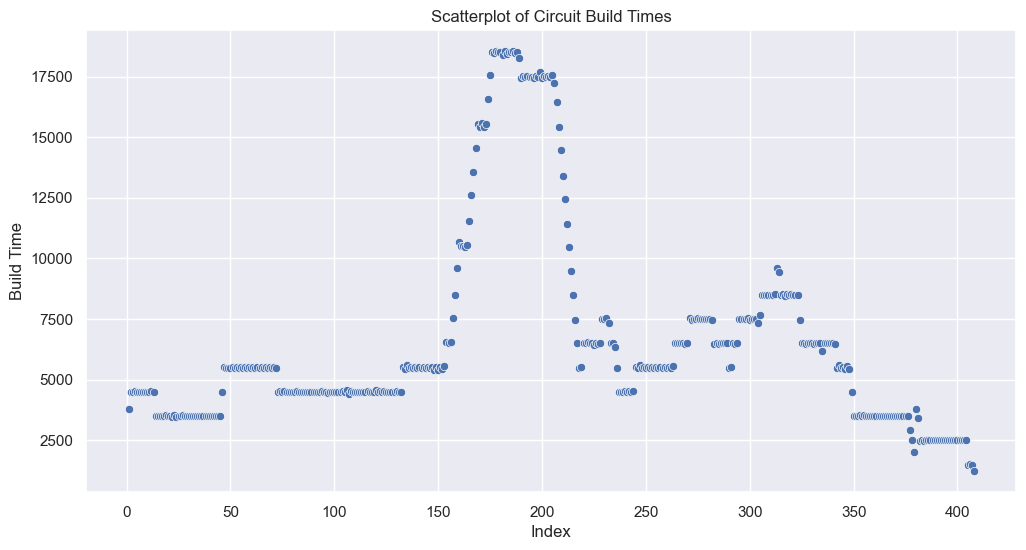

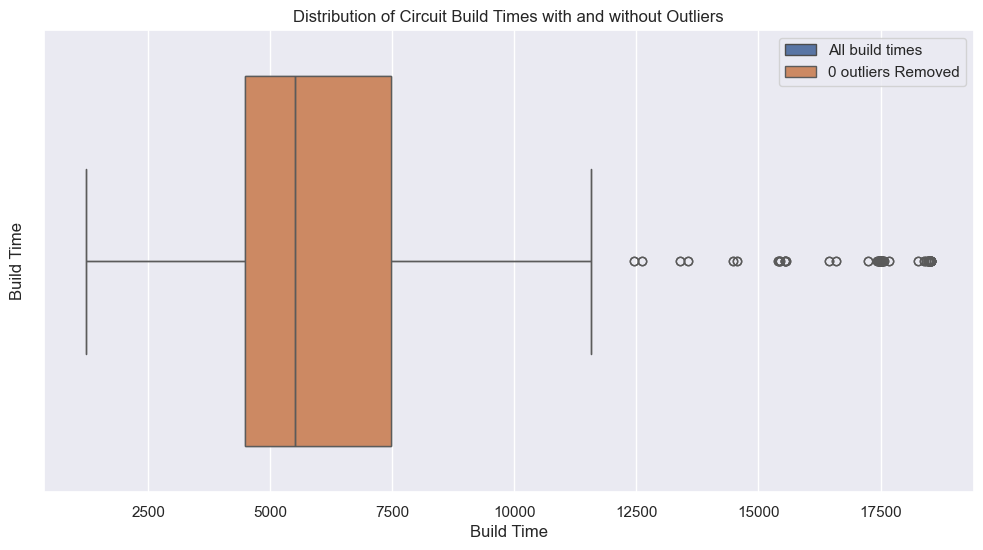

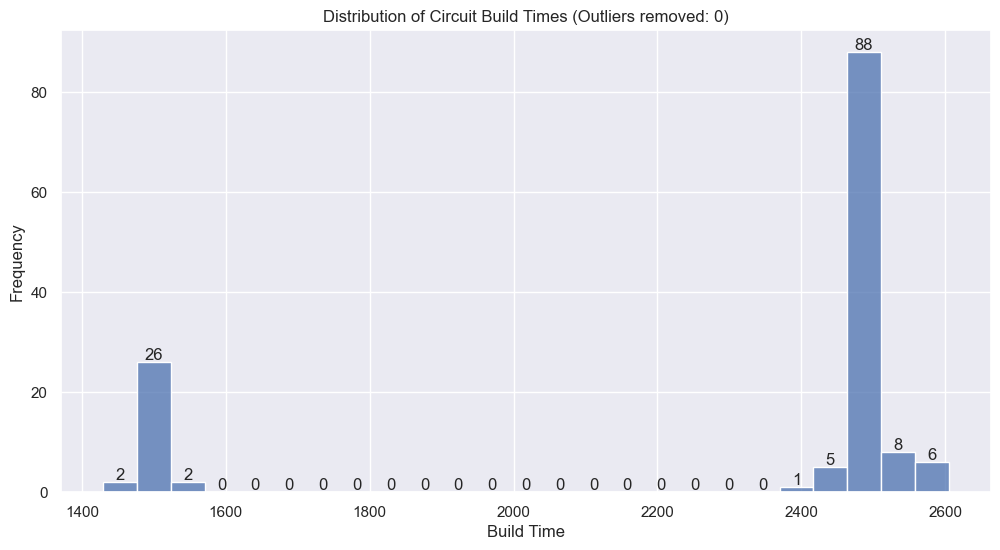

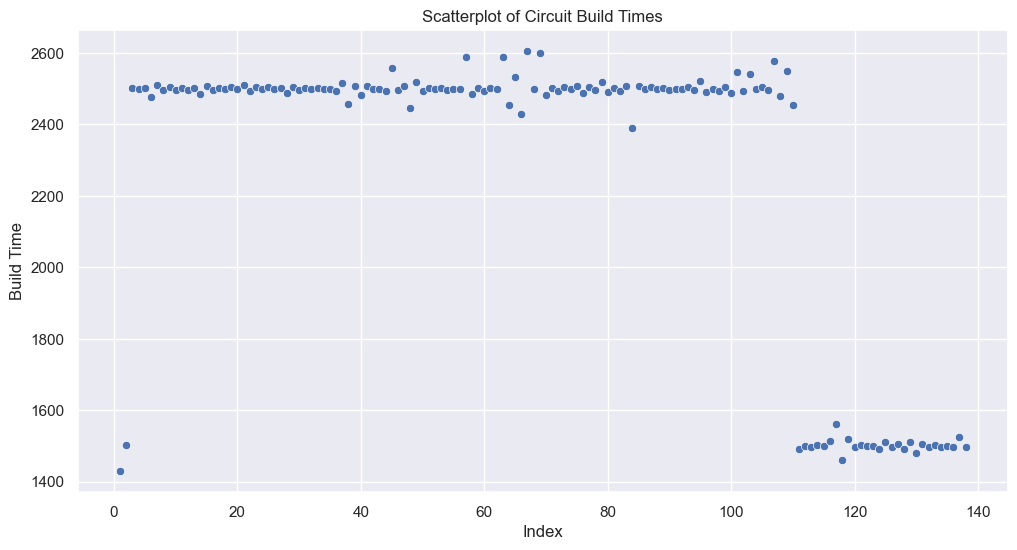

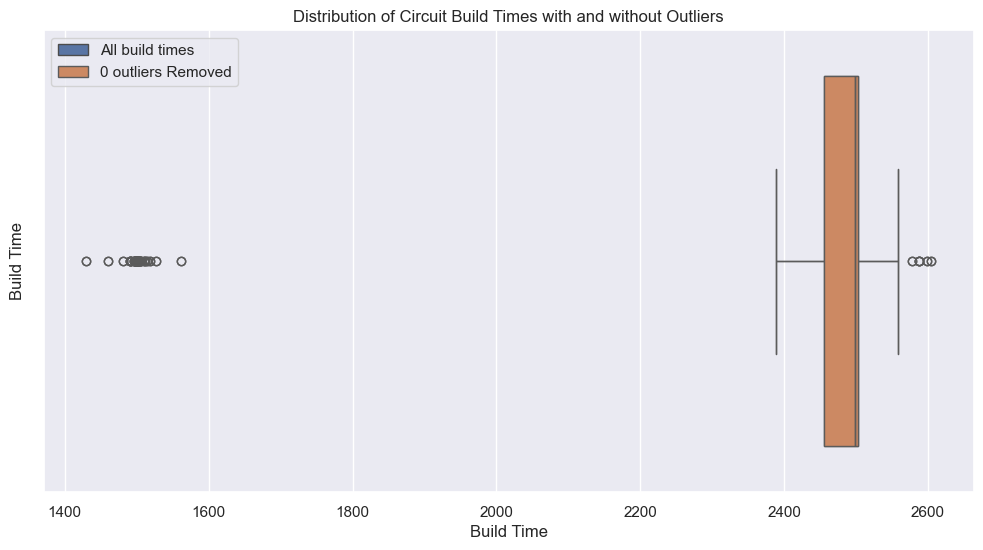

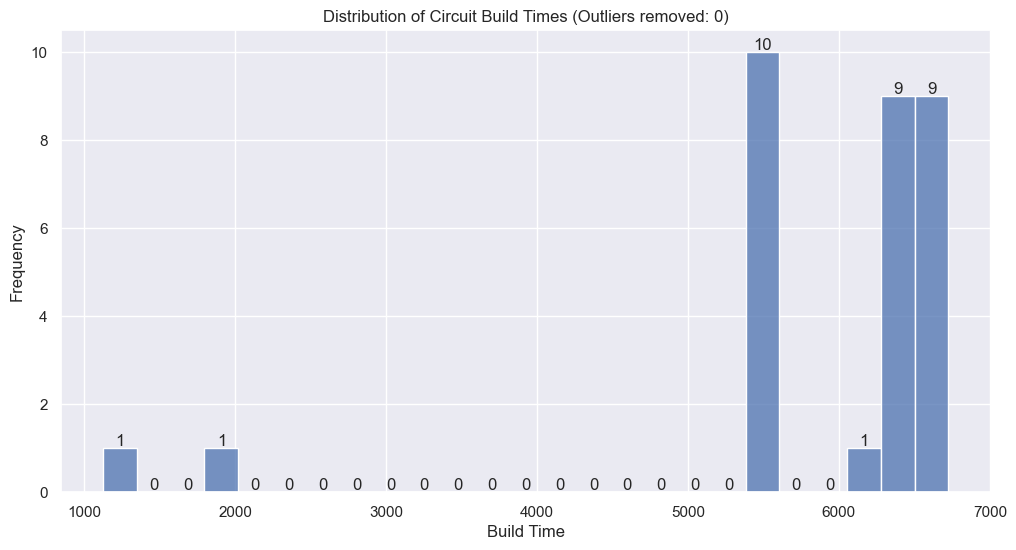

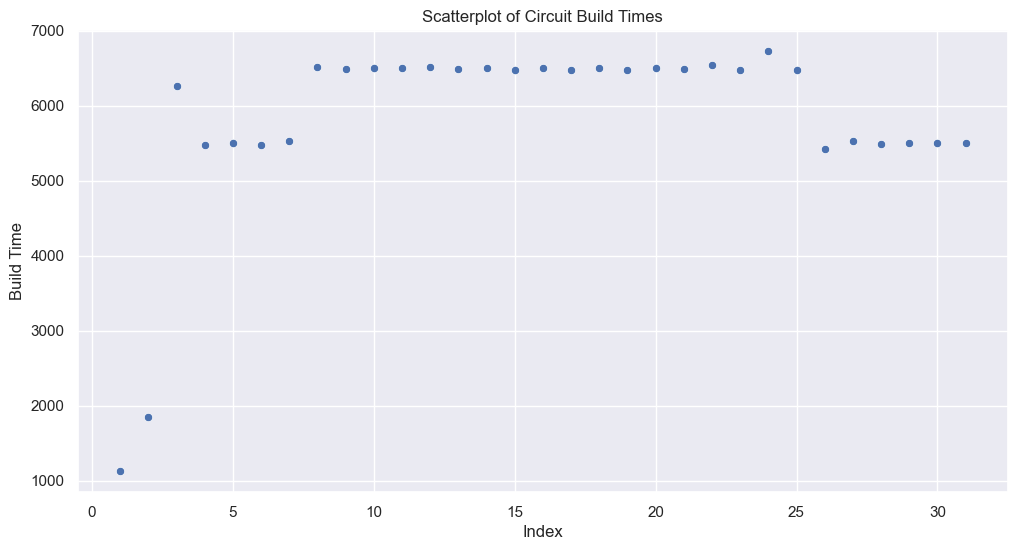

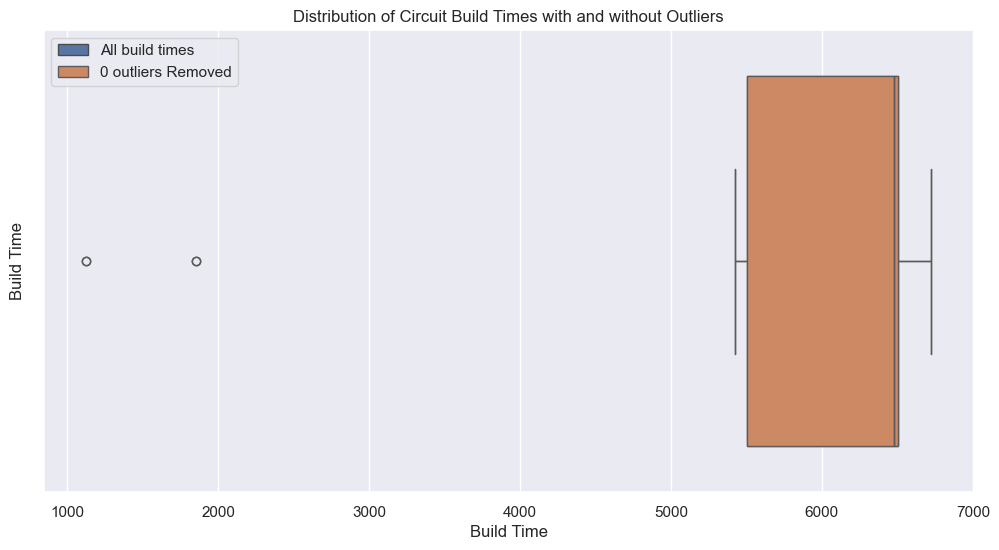

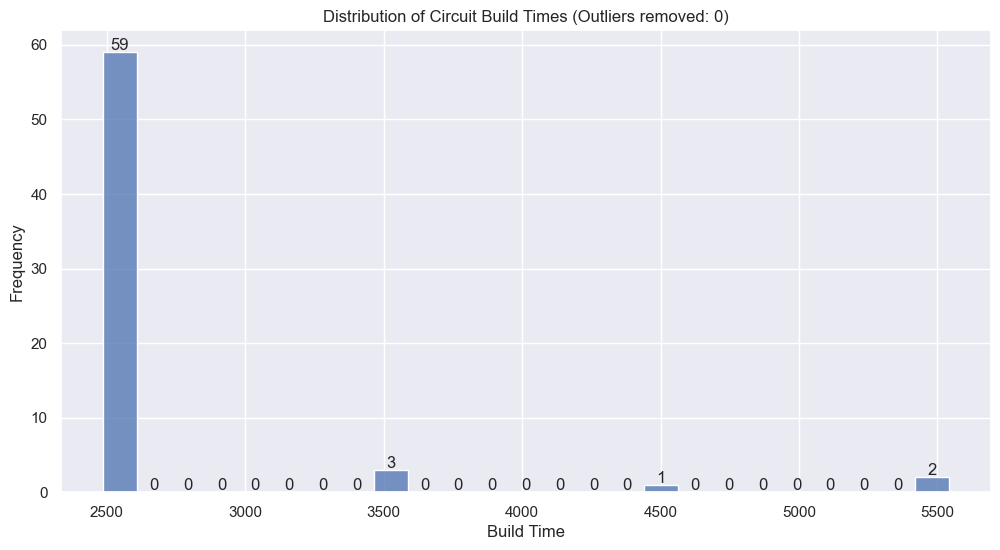

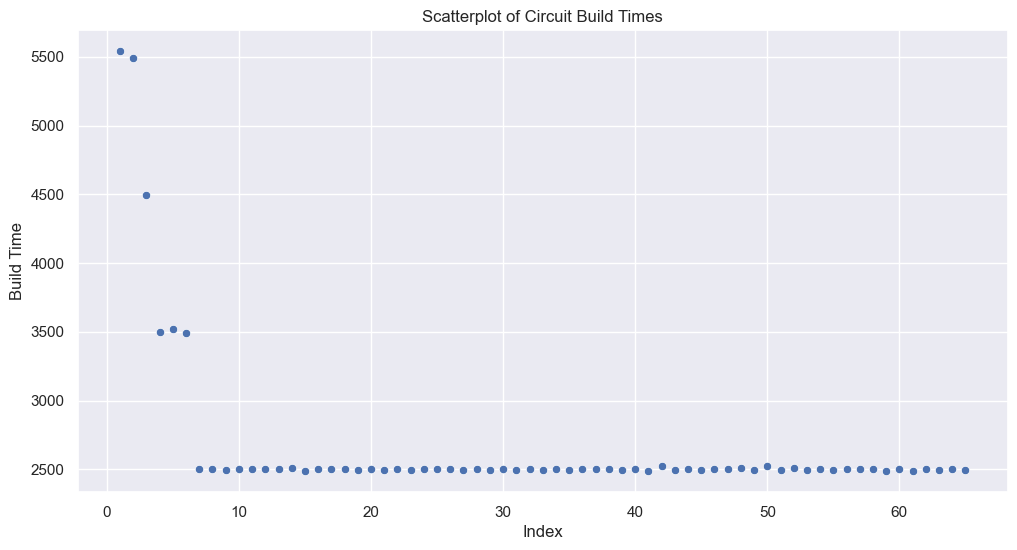

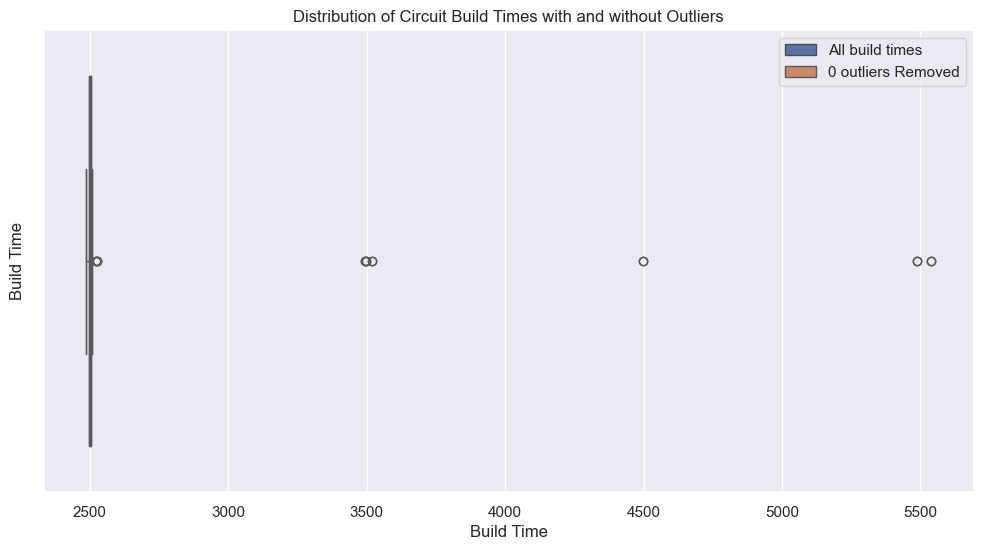

In [22]:
for i in range(1, 10):
    conclusions_filename = f'5000_run_with_ublock_{i}.log_build_time_conclusions.txt'
    # conclusions_filename = input("Enter the filename of the conclusions file to use: ")
    conclusions_file = f'../log_analysis/Filtered_logs/{conclusions_filename}'
    searchterm = r"Circuit timeout data:\s*(\d+\.\d+)ms"
    timeout_data, _ = extract_build_times_all(conclusions_file, conclusions_filename, searchterm)
    output_file_stats = f'../log_analysis/build_time_stats/{conclusions_filename}_stats.txt'
    build_time_stats(timeout_data, output_file_stats)
    circuit_build_times_histogram(timeout_data, 0, conclusions_filename)
    circuit_build_times_scatterplot(timeout_data, conclusions_filename)
    circuit_build_times_boxplot(timeout_data, 0, conclusions_filename)

for i in range(1,5):
    conclusions_filename = f'1_mil_no_ublock_{i}.log_build_time_conclusions.txt'
    # conclusions_filename = input("Enter the filename of the conclusions file to use: ")
    conclusions_file = f'../log_analysis/Filtered_logs/{conclusions_filename}'
    searchterm = r"Circuit timeout data:\s*(\d+\.\d+)ms"
    timeout_data, _ = extract_build_times_all(conclusions_file, conclusions_filename, searchterm)
    output_file_stats = f'../log_analysis/build_time_stats/{conclusions_filename}_stats.txt'
    build_time_stats(timeout_data, output_file_stats)
    circuit_build_times_histogram(timeout_data, 0, conclusions_filename)
    circuit_build_times_scatterplot(timeout_data, conclusions_filename)
    circuit_build_times_boxplot(timeout_data, 0, conclusions_filename)

Number of outliers: 0
Minimum build time: 1499.799501
Maximum build time: 7843.874812
Mean build time: 4654.723021814313


/tmp/ipykernel_261719/3943643851.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


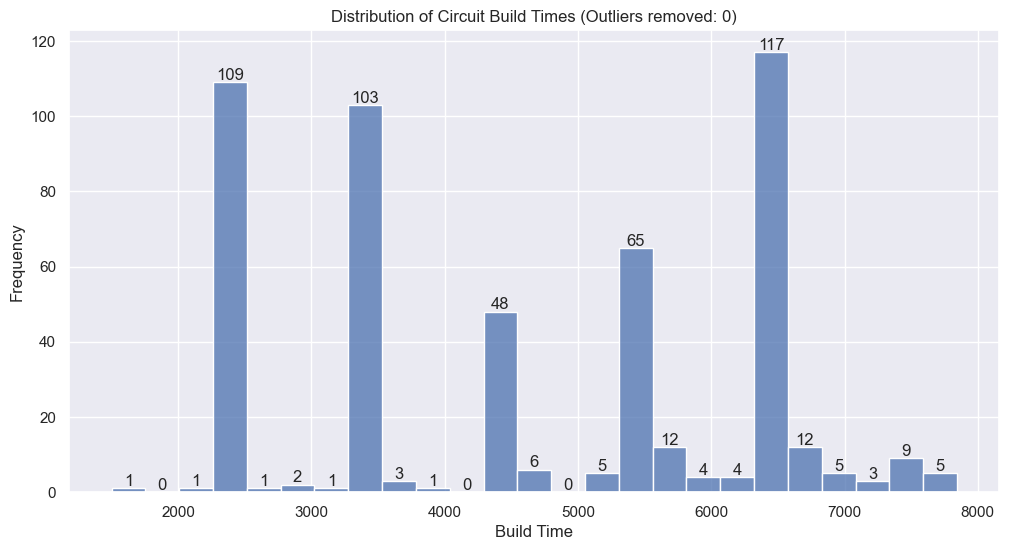

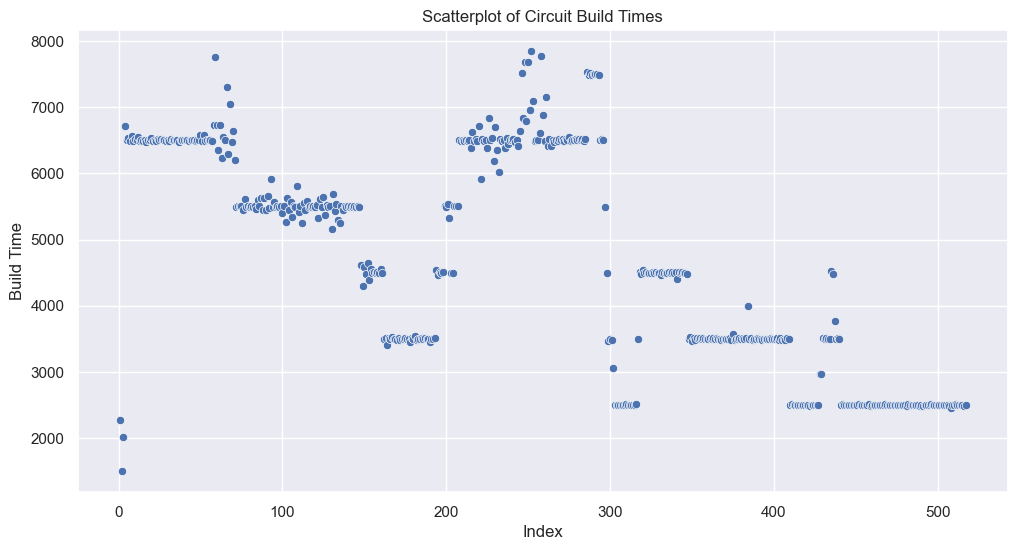

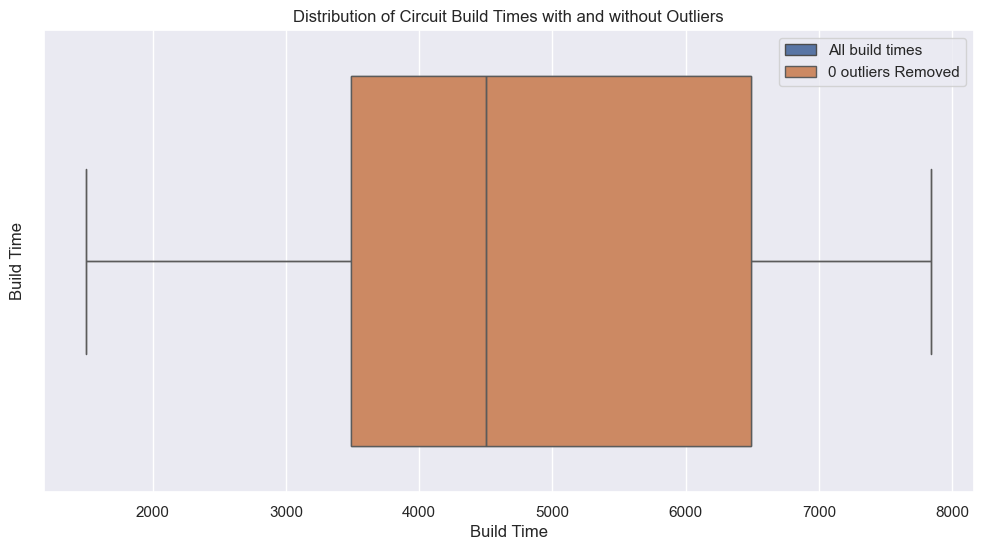

In [25]:
conclusions_filename = input("Enter the filename of the conclusions file to use: ")
conclusions_file = f'../log_analysis/Filtered_logs/{conclusions_filename}'
searchterm = r"Circuit timeout data:\s*(\d+\.\d+)ms"
timeout_data, _ = extract_build_times_all(conclusions_file, conclusions_filename, searchterm)
output_file_stats = f'../log_analysis/build_time_stats/{conclusions_filename}_stats.txt'
build_time_stats(timeout_data, output_file_stats)
circuit_build_times_histogram(timeout_data, 0, conclusions_filename)
circuit_build_times_scatterplot(timeout_data, conclusions_filename)
circuit_build_times_boxplot(timeout_data, 0, conclusions_filename)

In [13]:
def combine_files(input, output):
    with open(input, 'r') as input_file, open(output, 'a') as output_file:
        for line in input_file:
            output_file.write(line)

In [23]:
# combine_files('../log_analysis/1_mil_no_ublock.log_circuit_build_times_add_time.txt', '../log_analysis/5000_no_ublock_combined_circuit_build_time.txt')
# combine_files('../log_analysis/1_mil_no_ublock_2.log_circuit_build_times_add_time.txt', '../log_analysis/5000_no_ublock_combined_circuit_build_time.txt')
# combine_files('../log_analysis/1_mil_no_ublock_3.log_circuit_build_times_add_time.txt', '../log_analysis/5000_no_ublock_combined_circuit_build_time.txt')
# combine_files('../log_analysis/1_mil_no_ublock_4.log_circuit_build_times_add_time.txt', '../log_analysis/5000_no_ublock_combined_circuit_build_time.txt')

# combine_files('../log_analysis/5000_run_with_ublock_1.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
# combine_files('../log_analysis/5000_run_with_ublock_2.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
# combine_files('../log_analysis/5000_run_with_ublock_3.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
# combine_files('../log_analysis/5000_run_with_ublock_4.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
# combine_files('../log_analysis/5000_run_with_ublock_5.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
# combine_files('../log_analysis/5000_run_with_ublock_6.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
# combine_files('../log_analysis/5000_run_with_ublock_7.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
# combine_files('../log_analysis/5000_run_with_ublock_8.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')
# combine_files('../log_analysis/5000_run_with_ublock_9.log_circuit_build_times_add_time.txt', '../log_analysis/5000_with_ublock_combined_circuit_build_time.txt')

for i in range(1,10):
    combine_files(f'../log_analysis/Filtered_logs/5000_run_with_ublock_{i}.log_build_time_conclusions.txt', '../log_analysis/Filtered_logs/5000_with_ublock_combined_build_time_conclusions.txt')

for i in range(1,5):
    combine_files(f'../log_analysis/Filtered_logs/1_mil_no_ublock_{i}.log_build_time_conclusions.txt', '../log_analysis/Filtered_logs/5000_no_ublock_combined_build_time_conclusions.txt')